# Free-Energy Decomposition of Salt Effects on the Solubilities of Small Molecules and the Role of Excluded-Volume Effects

Stefan Hervø-Hansen<sup>a,&#42;</sup>, Lin Daoyang<sup>a</sup>, Kento Kasahara<sup>a</sup>, and Nobuyuki Matubayasi<sup>a,&#42;</sup>.<br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup>*</sup> To whom correspondence may be addressed: stefan@cheng.es.osaka-u.ac.jp and nobuyuki@cheng.es.osaka-u.ac.jp.


## PART 3: Analysis

## Import of Python Modules & Auxiliary Functions

In [1]:
# Notebook dependent libs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator)
import os, re, time, string, math
import parmed as pmd
import mdtraj as md
from math import isclose
from scipy import stats
from scipy import integrate
from uncertainties import unumpy

# Physical constants & useful conversions
Na = 6.02214076e23 # Avogadro constant [mol]
liter_to_cubeangstrom = 1e27
nm3_to_liter = 1e-24


homedir = !pwd
homedir = homedir[0]
ERMODHOME = "/home/stefan/ermod-0.3.7"
print(homedir)

/data4/stefan/Cavity-Formation


In [2]:
def BootstrapLinearRegression(xdata, ydata, bootstrapIterations=1e5, getDistribtion=False):
    '''Linear Regression with Parametric Bootstrapping.
========
Attributes:
xdata: List, 1d np.array; Sample points.
ydata: 2d np.array; Observed values for each sample point for each column.
bootstrapIterations: int; Number of bootstrapping iterations to be conducted.
getDistribtion: Bool; Option to return array of regression parameters from bootstrapping procedure.
========
Return: Tuble of polynormial parameters (mean, slope). If `getDistribtion=True` the tuble will also contain
numpy array of parameters from the individual bootstrapping iterations.
========
References:
https://bit.ly/3xHB1H1 # Bootstrap for dummies.
https://bit.ly/32WHIXd # Towards data science.
'''
    from copy import deepcopy
    import numpy as _np
    
    assert _np.shape(xdata)[0] == _np.shape(ydata)[1], 'xdata axis=0 size must equal ydata axis=1 size!'
    
    slopes = []; intercepts = []
    origin = deepcopy(ydata)
    for __ in range(int(bootstrapIterations)):
        for i, point in enumerate(origin.T):
            ydata.T[i] = _np.random.choice(point, size=len(point), replace=True)
            
        fit = _np.polyfit(xdata, ydata.mean(axis=0), 1)
        slopes.append(fit[0]); intercepts.append(fit[1])
        
    slopes = _np.array(slopes); meanSlope = slopes.mean(); stdSlope = slopes.std()
    intercepts = _np.array(intercepts); meanIntercept = intercepts.mean(); stdIntercept = intercepts.std()
        
    if getDistribtion:
        return ((meanSlope, stdSlope, slopes), (meanIntercept, stdIntercept, intercepts))
        
    
    return ((meanSlope, stdSlope), (meanIntercept, stdIntercept))

## Simulation Settings and Conditions

In [3]:
states = { # State of simulations, (outFreq is steps per frame)
          'vac': {'Nsteps':   1000000, 'OutFreq':  10}, #   1  nanoseconds, 100000 frames
          'sol': {'Nsteps':  10000000, 'OutFreq': 100}, #  20 nanoseconds,  100000 frames
          'ref': {'Nsteps':  25000000, 'OutFreq': 100}, #  50 nanoseconds,  250000 frames
}

salts = {
    'NaF':  {'cation': 'Na', 'anion': 'F' },
    'NaCl': {'cation': 'Na', 'anion': 'Cl'},
    'NaI':  {'cation': 'Na', 'anion': 'I' },
    'KF':   {'cation': 'K',  'anion': 'F' },
    'KCl':  {'cation': 'K',  'anion': 'Cl'},
    'KI':   {'cation': 'K',  'anion': 'I' },
    'RbF':  {'cation': 'Rb', 'anion': 'F' },
    'RbCl': {'cation': 'Rb', 'anion': 'Cl'},
    'RbI':  {'cation': 'Rb', 'anion': 'I' },
}

solutes = {
    'methanol':   {'SMILES': 'CO',      'Category': 'n-alcohols', 'Resname': 'MOH', 'dG_wat': -5.10, 'dG_NaCl_2.18M':  None},
    'ethanol' :   {'SMILES': 'CCO',     'Category': 'n-alcohols', 'Resname': 'EOH', 'dG_wat': -5.00, 'dG_NaCl_2.18M':  None},
    'n-propanol': {'SMILES': 'CCCO',    'Category': 'n-alcohols', 'Resname': 'PHO', 'dG_wat': -4.85, 'dG_NaCl_2.18M':  None},
    'n-butanol' : {'SMILES': 'CCCCO',   'Category': 'n-alcohols', 'Resname': 'BOH', 'dG_wat': -4.72, 'dG_NaCl_2.18M':  None},
    'n-pentanol': {'SMILES': 'CCCCCO',  'Category': 'n-alcohols', 'Resname': 'POH', 'dG_wat': -4.57, 'dG_NaCl_2.18M':  None},
    'n-hexanol':  {'SMILES': 'CCCCCCO', 'Category': 'n-alcohols', 'Resname': 'HHO', 'dG_wat': -4.40, 'dG_NaCl_2.18M': -3.71},
    
    'methane':    {'SMILES': 'C',       'Category': 'n-alkanes',  'Resname': 'MTH', 'dG_wat':  2.00, 'dG_NaCl_2.18M':  2.37},
    'ethane' :    {'SMILES': 'CC',      'Category': 'n-alkanes',  'Resname': 'ETH', 'dG_wat':  1.83, 'dG_NaCl_2.18M':  2.31},
    'propane':    {'SMILES': 'CCC',     'Category': 'n-alkanes',  'Resname': 'PRP', 'dG_wat':  2.00, 'dG_NaCl_2.18M':  2.54},
    'n-butane' :  {'SMILES': 'CCCC',    'Category': 'n-alkanes',  'Resname': 'BUT', 'dG_wat':  2.10, 'dG_NaCl_2.18M':  2.72},
    'n-pentane':  {'SMILES': 'CCCCC',   'Category': 'n-alkanes',  'Resname': 'PEN', 'dG_wat':  2.30, 'dG_NaCl_2.18M':  2.98},
    'n-hexane':   {'SMILES': 'CCCCCC',  'Category': 'n-alkanes',  'Resname': 'HEX', 'dG_wat':  2.48, 'dG_NaCl_2.18M':  3.30},
}

concentrations = {
     0.00: {'N_solute':1, 'N_water':10000, 'N_cation':0,   'N_anion':0},
#     0.25: {'N_solute':1, 'N_water':10000, 'N_cation':45,  'N_anion':45},
     0.50: {'N_solute':1, 'N_water':10000, 'N_cation':90,  'N_anion':90},
#     0.75: {'N_solute':1, 'N_water':10000, 'N_cation':135, 'N_anion':135},
     1.00: {'N_solute':1, 'N_water':10000, 'N_cation':180, 'N_anion':180}
}

GENERATE_ERMOD = False

## Solvation Free Energy Calculation


### Prepare ERmod analysis
<img style="float: right;width:319.5px;height:312.5px;" src="Figures/ermod.png" title="Simulation flow" >

The determination of solvation free energies and chemical potentials though the ERmod software is conducted in two stages as illustrated in the figure. First is the determination of the energy distribution functions from the simulation trajectories obtained from molecular dynamics using the subprogram `ermod`. Second is the solvation free energy is determined from the energy distribution functions though an approximate functional using the subprogram `slvfe`.

Documentation for the parameter file `parameters_er` which determines how the `ermod` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-ermod03/). In the python code below it can be noted many of the parameters has been given the keyword `[correct]`, these settings are dependent on the simulation settings and or the software being used and are thus recommended not to be changed if using the openMM setup above. The parameters given the keyword `[to be set]` are settings either collected from the output of the openMM script or set by the user, in specific the values for `maxins` and `engdiv` should be given by the user are given the default value of 1000 and 5 respectively.

Documentation for the parameter file `parameters_fe` which determines how the `slvfe` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-slvfe/). It is recommended not to change the parameters in this file with the exception of the temperature if conducting simulations at other temperatures than 298.15 Kelvin, and the volume. In the code below the average volume input is calculated as an average volume from the two ensemble volume averages.

In [4]:
# ERmod settings
state_parameters = {
    'refs': {'state': 3, 'Ninserts': 200, 'Ndivisions': 5},
    'soln': {'state': 1, 'Ninserts': 200, 'Ndivisions': 10}
}

ermod_script = """
&ene_param
      slttype = {state},     ! Choose system; 1: Solution system  2,3: Reference                     [to be set]
      boxshp = 1,            ! Boxtype                                                               [correct]   
      estype = 2,            ! Ensemble; 1: NVT   2: NPT                                             [correct]   
      inptemp = 298.15,      ! Temperature (in Kelvin)                                               [correct]   
      ljformat = 2,          ! LJ form                                                               [correct]   
      cmbrule = 1,           ! Combination rule                                                      [correct]   
      ljswitch = 1,          ! Switching function for smooth LJ truncation                           [correct]   
      upljcut = 12,          ! Upper limit for LJ cutoff switching function (in Angstrom)            [correct]   
      lwljcut = 10,          ! Lower limit for LJ cutoff switching function (in Angstrom)            [correct]   
      cltype = 2,            ! Treatment of Coulomb interaction (2=PME)                              [correct]   
      elecut = 12.0,         ! Cutoff of the real-space electrostatic interaction (in angstrom)      [correct]   
      ewtoler = 0.00001,     ! Error tolerance in Ewald                                              [correct]   
      splodr = 5,            ! Order of spline function used in PME                                  [correct]   
      ms1max = {PMEnodes_x}, ! Number of meshes in PME (x)                                           [to be set] 
      ms2max = {PMEnodes_y}, ! Number of meshes in PME (y)                                           [to be set] 
      ms3max = {PMEnodes_z}, ! Number of meshes in PME (z)                                           [to be set] 
      maxins = {Ninserts},   ! Number of inserts (chosen freely, for reference ONLY)                 [to be set] 
      engdiv = {Ndivisions}, ! Number of divisions of the total simulation length (chosen freely)    [to be set] 
/
&hist
      eclbin=5.0e-2, ecfbin=2.0e-3, ec0bin=2.0e-4, finfac=10.0e0,
      ecdmin=-100.00, ecfmns=-0.20e0, ecdcen=0.0e0, eccore=55.0e0,
      ecdmax=1.0e11, pecore=200
/
"""
    
slvfe_script = """
&fevars
clcond    = "merge",       ! Calculation type, "merge" / "basic" / "range"
numsln    = {Nsol_blocks}, ! Number of trajectory blocks in solution system
numref    = {Nref_blocks}, ! Number of trajectory blocks in reference system
numdiv    = {Nsol_blocks}, ! Number of division for statistics, usually set equal to numsln
avevolume = {avgV},        ! Average volume sampled in simulation (in Angstrom^3)

ljlrc     = 'yes',         ! Long-range correction of the Lennard-Jones interaction (avevolume must be specified)
uvread    = "yes",         ! "not" if average solute-solvent energy is calculated from engsln, instead of aveuv.tt
slfslt    = "yes",         ! "not" if the solute self energy is not read
infchk    = "yes",         ! Enable error analysis for the logarithmic-mesh part
inptemp   = 298.15,        ! Input Temperature in Kelvin
cumuint   = 'yes',         ! Enable running integral calculations.
/
"""

### Generate ERmod Files

The following cell is fairly complicated and uses a mix of bash and python. While ERmod provides tools to assist in the construction of input files based on many popular molecular dynamics packages log files openMM is still yet to be supported. In the following we manually create the files. The steps are as follow:

1. Use the ERmod's `gen_structure` script to generate non-complete input scripts as well as the folders refs and soln containing pair-energy distributions at $λ=0$ and $λ=1$, respectively.
2. For soln and refs: Construct a `parameter_er` file as previously described, with updated PME parameters.
3. For soln and refs: Edit the `MDinfo? file containing the number of frames in the solution and reference state.
4. For soln and refs: Create a symlink named `HISTORY` linking to the joint trajectory for the solution and reference state.
5. For refs: Create a symlink named `SltConf` linking to the isolated trajectory of PEO. The conformational enemble of PEO can be controlled with the parameter `confEnsemble` taking the values `solvated` or `vacuum`.
6. Create the `parameters_fe` file with the main edit being the average volume sampled at $λ=1$ for long-range correction of Lennard-Jones interactions.

In [5]:
%cd -q $homedir
if GENERATE_ERMOD:
    water_done = False
    for solute, solute_details in solutes.items():
        for salt, salt_details in salts.items():
            for conc, conc_details in concentrations.items():
                if conc == 0 and water_done == False:
                    %cd -q $homedir/Simulations/$solute/No_salt
                    REFDIR  = '{homedir}/Simulations/References/No_salt'.format(homedir=homedir)
                    water_done = True
                elif conc == 0 and water_done == True:
                    continue
                else:
                    conc = '{0:.2f}'.format(conc)
                    %cd -q $homedir/Simulations/$solute/$salt/$conc
                    REFDIR = '{homedir}/Simulations/References/{salt}/{conc}'.format(homedir=homedir, salt=salt, conc=conc)
                    
                resname = solute_details['Resname']
                !echo $resname | /usr/bin/python2 $ERMODHOME/tools/gromacs/gen_structure --top Topology_stand_alone.top
                WORKDIR = os.getcwd()
                    
                #########
                # ERMOD #
                #########
                for ermodstate in ['soln', 'refs']:
                    %cd -q $WORKDIR/$ermodstate
                    with open('../run.out', 'r') as logfile:
                        lines = logfile.readlines()
                    logfile.close()
                    index = [idx for idx, s in enumerate(lines) if 'PARTICLE MESH EWALD PARAMETERS' in s][0]
                    PME_spacing = re.findall("([0-9]+[,.]+[0-9]+)", lines[index+1])
                    N_gridpoints = (*re.findall("([0-9]+)", lines[index+2]),
                                    *re.findall("([0-9]+)", lines[index+3]),
                                    *re.findall("([0-9]+)", lines[index+4]))
                    parameters = state_parameters[ermodstate]
                    with open('parameters_er', 'w') as f:
                        f.write(ermod_script.format(state=parameters['state'], Ninserts=parameters['Ninserts'], Ndivisions=parameters['Ndivisions'],
                                                    PMEnodes_x=N_gridpoints[0], PMEnodes_y=N_gridpoints[1], PMEnodes_z=N_gridpoints[2]))
                    f.close()
                    with open('MDinfo', 'r+') as f:
                        lines = f.readlines()
                        num_frames =  int(states[ermodstate[:3]]['Nsteps']/states[ermodstate[:3]]['OutFreq'])
                        lines[0] = lines[0].replace('FRAMES', str(num_frames))
                        f.seek(0)
                        f.truncate()
                        for line in lines:
                            f.write(line)
                    f.close()

                    if ermodstate == 'soln':
                        !ln -s ../trajectory.xtc HISTORY
                    if ermodstate == 'refs':
                        !ln -s $REFDIR/trajectory.xtc HISTORY
                        !ln -s $homedir/Simulations/$solute/Solute/trajectory.xtc SltConf
                                                    
                #########
                # SLVFE #
                #########
                %cd -q $WORKDIR
                vol_data = np.loadtxt('{refdir}/output.dat'.format(refdir=REFDIR),
                                      usecols=4, skiprows=1)
                avgVolume = vol_data.mean()*1000
                with open('parameters_fe', 'w') as f:
                    f.write(slvfe_script.format(Nsol_blocks=state_parameters['soln']['Ndivisions'],
                                            Nref_blocks=state_parameters['refs']['Ndivisions'],
                                            avgV=avgVolume))
                print('Wrote ERmod analysis files to '+os.getcwd())
        water_done = False

### Submit ERmod analysis

In [6]:
%cd -q $homedir

submit_script="""#!/bin/bash
#PBS -N {solute}_{salt}_{conc}_ermod
#PBS -l nodes=1:ppn=36:nu-g             # 1 node, 36 cores, nu partition
#PBS -e ermod.err                       # Error output
#PBS -o ermod.out                       # Output file name

source ~/.bashrc
source ~/.bash_profile

cd {path}

# Pair-energy calculation in solution state
cd soln
mpirun -np 36 ermod
cd ..

# Pair-energy calculation in reference state
cd refs
mpirun -np 36 ermod
cd ..

# Calculate solvation free energy
slvfe
"""

%cd -q $homedir
if GENERATE_ERMOD:
    water_done = False
    for solute, solute_details in solutes.items():
        for salt, salt_details in salts.items():
            for conc, conc_details in concentrations.items():
                if conc == 0 and water_done == False:
                    %cd -q $homedir/Simulations/$solute/No_salt
                    water_done = True
                elif conc == 0 and water_done == True:
                    continue
                else:
                    conc = '{0:.2f}'.format(conc)
                    %cd -q $homedir/Simulations/$solute/$salt/$conc
        
                with open('submit_ermod.pbs', 'w') as f:
                    f.write(submit_script.format(solute=solute, salt=salt, conc=conc, path=os.getcwd()))
                f.close()
                !qsub submit_ermod.pbs
                time.sleep(1) # Safety in submission of jobs: can cause problems if too fast
        water_done = False

## Convergence of Solvation Free Energies  <br> Case: Methanol in 0.5 M NaCl

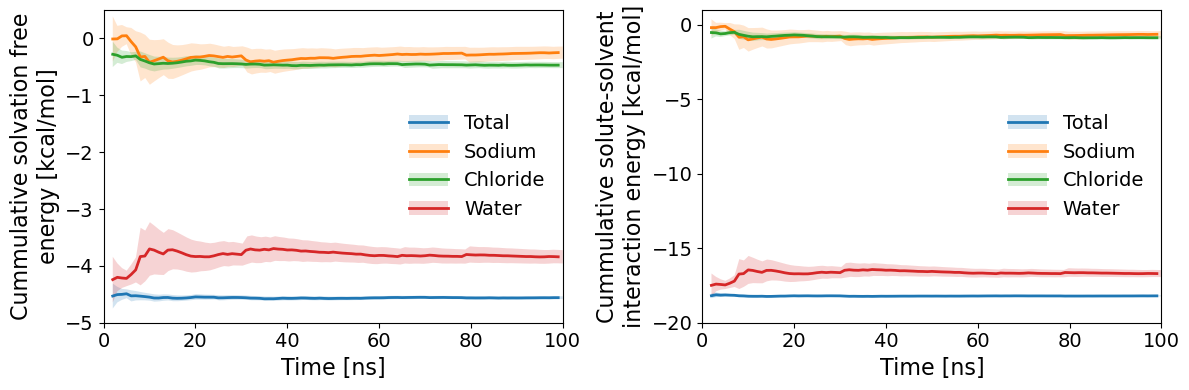

In [7]:
%cd -q $homedir
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(2*6,4))

# SOLVATION ENERGY AND FREE ENERGY ANALYSIS #

with open('Simulations/methanol/NaCl/0.50/Convergence_Test/ermod.out') as f:
    lines = f.readlines()
f.close()
for lineNR, line in enumerate(lines):
    if "cumulative average & 95% error for solvation energy" in line:
        slve_line = lineNR
    if "cumulative average & 95% error for solvation free energy" in line:
        slvfe_line = lineNR

slvfe_data = np.loadtxt('Simulations/methanol/NaCl/0.50/Convergence_Test/ermod.out',
                        skiprows=slvfe_line+3, usecols=(range(9)), unpack=True)

slve_data  = np.loadtxt('Simulations/methanol/NaCl/0.50/Convergence_Test/ermod.out',
                        skiprows=slve_line+3, usecols=(range(9)), unpack=True, max_rows=98)

time = np.arange(100/99, 100)
labels = ['Total', 'Sodium', 'Chloride', 'Water']
handles = []
for i, solvent_idx in enumerate(range(1,8,2)):
    line = axes[0].plot(time[1:], slvfe_data[solvent_idx], label=labels[i], linewidth=2)
    fill = axes[0].fill_between(slvfe_data[0]*(100/99), y1=slvfe_data[solvent_idx]+slvfe_data[solvent_idx+1],
                           y2=slvfe_data[solvent_idx]-slvfe_data[solvent_idx+1], alpha=0.2)
    
    axes[1].plot(time[1:], slve_data[solvent_idx], label=labels[i], linewidth=2)
    axes[1].fill_between(slve_data[0]*(100/99), y1=slve_data[solvent_idx]+slve_data[solvent_idx+1],
                         y2=slve_data[solvent_idx]-slve_data[solvent_idx+1], alpha=0.2)
      
    handles.append((line[0],fill))

ylabels = ['Cummulative solvation free\nenergy [kcal/mol]', 'Cummulative solute-solvent\ninteraction energy [kcal/mol]']
for i, ax in enumerate(axes):
    ax.set_xlim(0, 100)
    ax.set_xlabel('Time [ns]', fontsize=16)
    ax.set_ylabel(ylabels[i], fontsize=16)
    ax.legend(loc=0, handles=handles, labels=labels, prop={'size': 14}, frameon=False)
    ax.tick_params(axis='both', labelsize=14)

axes[0].set_ylim(-5, 0.5)
axes[1].set_ylim(-20, 1)
    
fig.tight_layout()
fig.savefig('Figures/SLVFE_SLVE_convergence.pdf', bbox_inches='tight')

In [8]:
%cd -q $homedir

# This cell takes a long time to run and requires the simulation to be present.
# To avoid this set `CALCULATE_RDF=False` to skip this cell
CALCULATE_RDF = False

if CALCULATE_RDF:
    pdb = md.load_pdb('Simulations/methanol/NaCl/0.50/Initial.pdb')
    indices = pdb.topology.select('not water')
    
    traj = md.load_xtc('Simulations/methanol/NaCl/0.50/trajectory.xtc',
                       top='Simulations/methanol/NaCl/0.50/Initial.pdb', atom_indices=range(indices.max()+1))

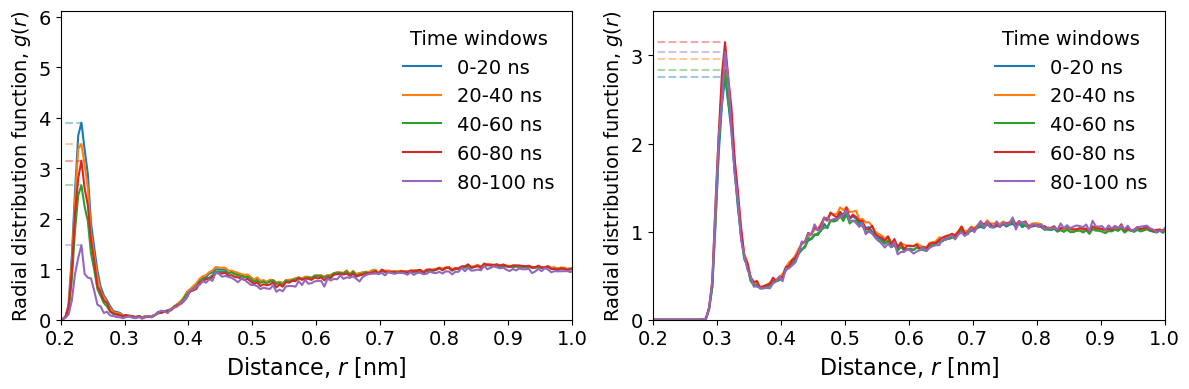

In [10]:
%cd -q $homedir
if CALCULATE_RDF:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    
    pairs_Cl = traj.topology.select_pairs('resid 0 and element O', 'resname CL')
    pairs_Na = traj.topology.select_pairs('resid 0 and element O', 'resname NA')
    
    labels = ['0-20 ns', '20-40 ns', '40-60 ns', '60-80 ns', '80-100 ns']
    n_divisions = 5
    for i in range(n_divisions): # Dividing the trajectory into 5 parts (20 ns each)
        rdf = md.compute_rdf(traj[500000//n_divisions*i:500000//5*(n_divisions+1)], pairs_Na, r_range=(0, 1.5))
        peak_idx = np.argmax(rdf[1])
        axes[0].plot(rdf[0], rdf[1], label=labels[i])
        axes[0].hlines(rdf[1][peak_idx], 0, rdf[0][peak_idx], linestyle='dashed', alpha=0.4, color='C{}'.format(i))
        
        rdf = md.compute_rdf(traj[500000//n_divisions*i:500000//5*(n_divisions+1)], pairs_Cl, r_range=(0, 1.5))
        peak_idx = np.argmax(rdf[1])
        axes[1].plot(rdf[0], rdf[1], label=labels[i])
        axes[1].hlines(rdf[1][peak_idx], 0, rdf[0][peak_idx], linestyle='dashed', alpha=0.4, color='C{}'.format(i))
    
    for ax in axes:
        leg = ax.legend(loc=0, frameon=False, prop={'size': 14})
        leg.set_title('Time windows',prop={'size':14})
        ax.set_xlabel('Distance, $r$ [nm]', fontsize=16)
        ax.set_ylabel('Radial distribution function, $g(r)$', fontsize=14)
        ax.tick_params(axis='both', labelsize=14)
    
    axes[0].set_xlim(0.2,1.0)
    axes[1].set_xlim(0.2,1.0)
    axes[0].set_ylim(0,6.1)
    axes[1].set_ylim(0,3.5)
    axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    
    
    fig.tight_layout()
    fig.savefig('Figures/RDF_convergence.pdf', bbox_inches='tight')

## Solvation Free Energies & Setschenow Coefficients: The First Look

The solvation free energy within the framework of energy-representation theory of solvation can be written as<
$$
\Delta G_{\mathrm{sol}} = \Delta G_{\mathrm{self}} + \Delta G_{\mathrm{anion}} + \Delta G_{\mathrm{cation}} + \Delta G_{\mathrm{water}}
$$
where the individual terms constitute the chemical species' contribution to the solvation free energy of the solute. The solvation free energies given a set of conditions can be found in the `ermod.out` files. 

In this section we will first inspect the self-energy, being the first term of the previous equation. Next the solvation free energy's variation with salt will be visualized. Finally we will visualize the individual specie's contribution to the Setschenow coefficients as we may write a solvent-species decomposition of the Setschenow coefficient as
$$
k_s = \frac{1}{RT} \left( \frac{\partial \Delta G_{\mathrm{cation}}}{\partial c_\mathrm{s}} + \frac{\partial \Delta G_{\mathrm{anion}}}{\partial c_\mathrm{s}} + \frac{\partial \Delta G_{\mathrm{water}}}{\partial c_\mathrm{s}} \right).
$$
The code for visualizing the data is utilizing the raw output files given by ERmod.

### Solute self-energy

In [7]:
self_energies = np.zeros(shape=(len(solutes), (len(concentrations)*len(salts))))

print('Self contribution ranges in kcal/mol across all types of salts and salt concentrations:')
water_done = False
for i, solute in enumerate(solutes):
    j = 0
    for salt in salts:
        for conc in concentrations:
            if conc == 0 and water_done == False:
                with open('Simulations/{solute}/No_salt/ermod.out'.format(solute=solute)) as f:
                    lines = f.readlines()
                f.close()
                water_done = True
            elif conc == 0 and water_done == True:
                continue
            else:
                conc = '{0:.2f}'.format(conc)
                with open('Simulations/{solute}/{salt}/{conc}/ermod.out'.format(solute=solute, salt=salt, conc=conc)) as f:
                    lines = f.readlines()
                f.close()
                
            for line in lines:
                if "Self-energy of the solute" in line:
                    self_energies[i,j] = float(line.split()[5])
            j+=1
    print('{}: {:.3} to {:.3} kcal/mol'.format(solute, self_energies[i].min(), self_energies[i].max()))

Self contribution ranges in kcal/mol across all types of salts and salt concentrations:
methanol: -0.0001 to 0.0 kcal/mol
ethanol: -0.0001 to 0.0 kcal/mol
n-propanol: -0.0001 to 0.0 kcal/mol
n-butanol: -0.0001 to 0.0 kcal/mol
n-pentanol: -0.0001 to 0.0 kcal/mol
n-hexanol: -0.0001 to 0.0 kcal/mol
methane: 0.0 to 0.0 kcal/mol
ethane: 0.0 to 0.0 kcal/mol
propane: 0.0 to 0.0 kcal/mol
n-butane: 0.0 to 0.0 kcal/mol
n-pentane: 0.0 to 0.0 kcal/mol
n-hexane: 0.0 to 0.0001 kcal/mol


### Obtaining slvfes and concentrations

In [8]:
%cd -q $homedir
slvfe                   = np.zeros(shape=(len(solutes), len(salts), len(concentrations)))
slvfe_err               = np.zeros(shape=(len(solutes), len(salts), len(concentrations)))
sampled_concentrations  = np.zeros(shape=(len(solutes), len(salts), len(concentrations)))

for i, solute in enumerate(solutes):
    for j, salt in enumerate(salts):
        for k, conc in enumerate(concentrations):
            if conc == 0: # Solute in neat water
                with open('Simulations/{}/No_salt/ermod.out'.format(solute)) as f:
                    lines = f.readlines()
                f.close()
                for lineNR, line in enumerate(lines):
                    if "cumulative average & 95% error for solvation free energy" in line:
                        slvfe[i,j,k] = lines[lineNR+10].split()[1]
                        slvfe_err[i,j,k] = lines[lineNR+10].split()[2]

            else: # Solute in salt solution
                C = '{0:.2f}'.format(conc)
                with open('Simulations/{}/{}/{}/ermod.out'.format(solute, salt, C)) as f:
                    lines = f.readlines()
                f.close()
                for lineNR, line in enumerate(lines):
                    if "cumulative average & 95% error for solvation free energy" in line:
                        slvfe[i,j,k] = lines[lineNR+11].split()[1]
                        slvfe_err[i,j,k] = lines[lineNR+11].split()[2]
                
                V = np.loadtxt('Simulations/{}/{}/{}/output.dat'.format(solute, salt, C),
                               usecols=(4), unpack=True)
                if C == '0.50':
                    N = 90
                elif C == '1.00':
                    N = 180
                sampled_concentrations[i,j,k] = N/ (V.mean()*nm3_to_liter*Na)
                
slvfe = unumpy.uarray(slvfe, slvfe_err)

### Solvation free energy variation with salt 

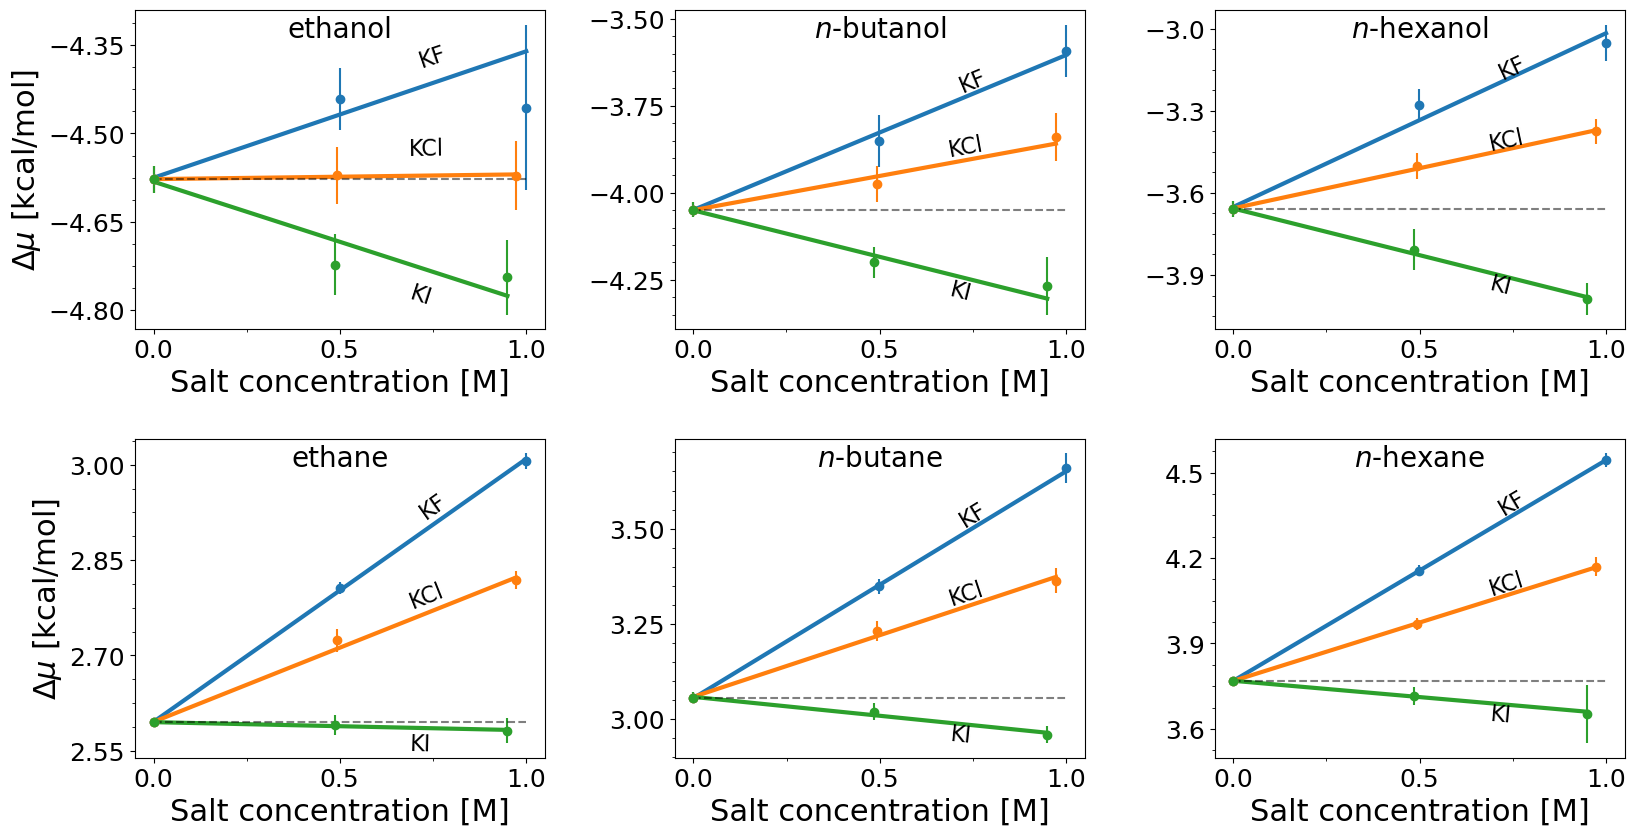

In [25]:
fig, axes = plt.subplots(2,3, figsize=(17, 9))

ctrl_solute = 0
for i, solute in enumerate(solutes):
    if i%2 == 1: # Every second solute starting with ethanol
        ctrl_salt = 0
        for j, salt in enumerate(salts):
            if j >= 3 and j <= 5: # Choose potassium salts
                # Conduct linear regression
                fit = np.polyfit(sampled_concentrations[i,j], unumpy.nominal_values(slvfe[i,j]),
                                 deg=1, w=1/unumpy.std_devs(slvfe[i,j]))
                fit_fn = np.poly1d(fit)
                
                ax = axes[ctrl_solute//3,ctrl_solute%3]
                ax.errorbar(sampled_concentrations[i,j], unumpy.nominal_values(slvfe[i,j]), yerr=unumpy.std_devs(slvfe[i,j]),
                            fmt='o', ms=6, color='C{}'.format(ctrl_salt))
                ax.plot(sampled_concentrations[i,j], fit_fn(sampled_concentrations[i,j]),
                        lw=3, ms=10, color='C{}'.format(ctrl_salt))
                if (fit[0] > 0 and ctrl_solute//3 == 1) or (fit[0] < 0 and ctrl_solute//3 == 0):
                    factor = 1.01
                else:
                    factor = 0.99
                ax.text(x=0.5*(sampled_concentrations[i,j,-1]+sampled_concentrations[i,j,-2]),
                        y=factor*(0.5*(fit_fn(sampled_concentrations[i,j,-1])+fit_fn(sampled_concentrations[i,j,-2]))),
                        s=salt, rotation=np.degrees(np.arctan(fit[0])), transform_rotates_text=True, horizontalalignment='center', 
                        verticalalignment='center', fontsize=16)
                ctrl_salt+=1
        
        if "n-" in solute:
            s = solute.split(sep='-')[1]
            ax.set_title('$\it{{n}}$-'+s, pad=-20, y=1.001, fontsize=20)
        else:
            ax.set_title(solute, pad=-20, y=1.001, fontsize=20)
        ax.set_xlabel('Salt concentration [M]', fontsize=22)
        ax.hlines(unumpy.nominal_values(slvfe[i,j,0]) ,0, 1.0, color='black', alpha=0.5, linestyle='dashed')
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(MultipleLocator(0.25))
        ax.yaxis.set_major_locator(MaxNLocator(4))
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xticks([0, 0.5, 1.0])
        ax.tick_params(axis='both', labelsize=18)
        axes[ctrl_solute//3][0].set_ylabel('$\Delta \mu$ [kcal/mol]', fontsize=22)
        ctrl_solute+=1
        
fig.tight_layout(pad=3)        
fig.savefig('Figures/Slvfe_with_salt.pdf', bbox_inches='tight')

### Species decomposition of the Setschenow coefficient

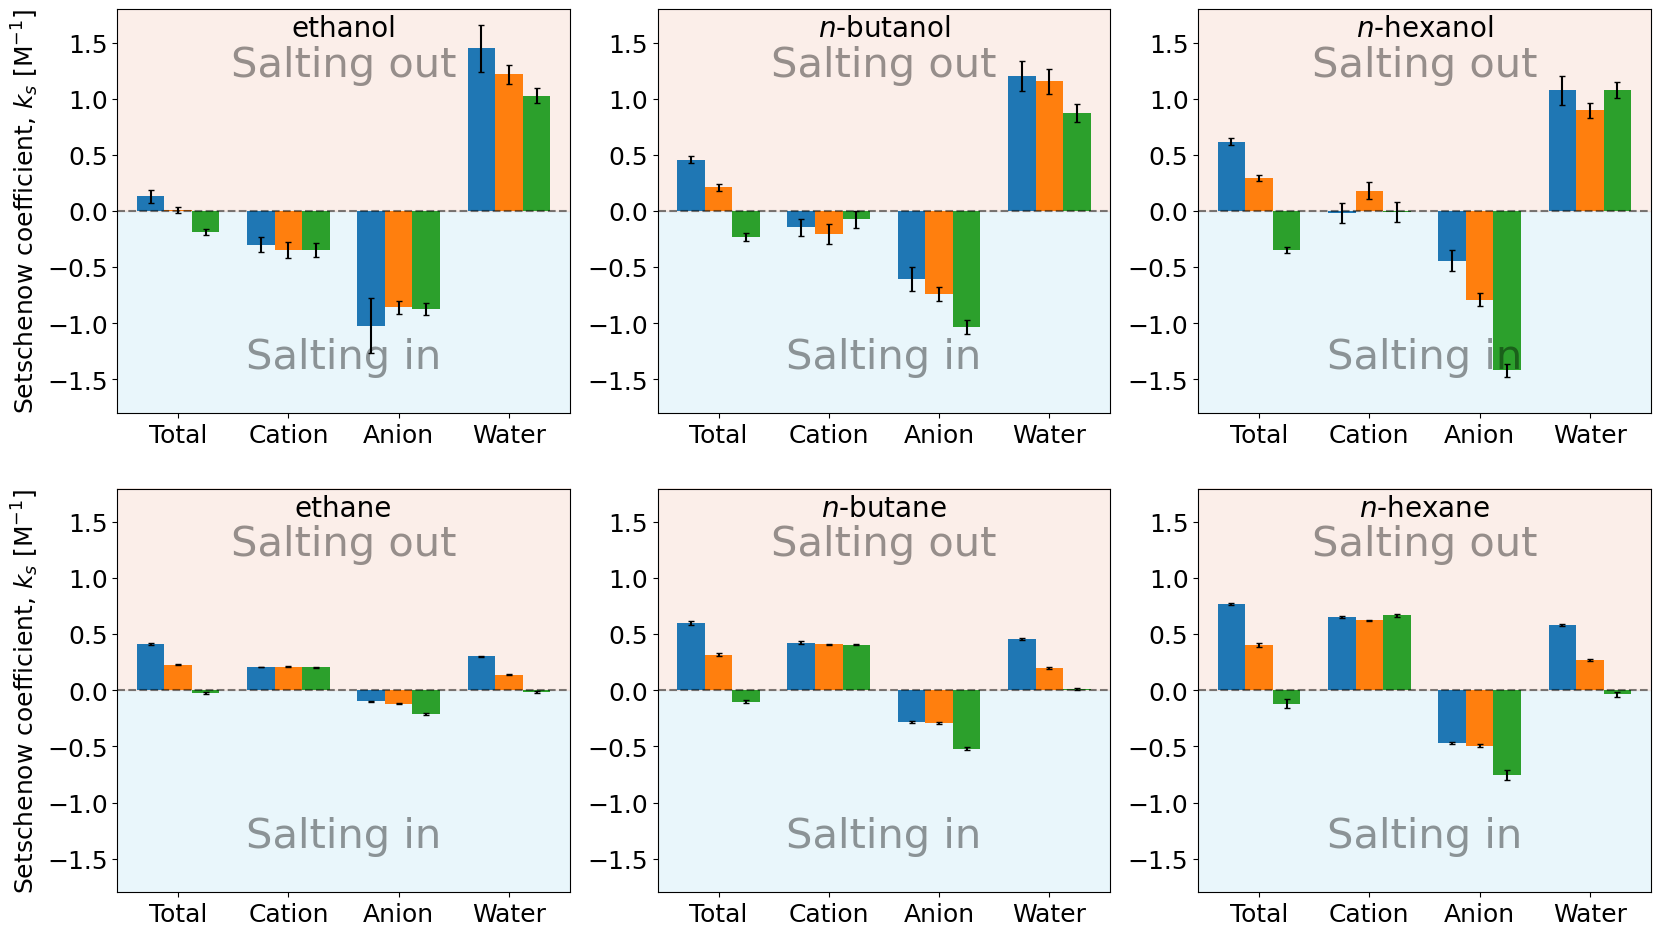

In [32]:
fig, axes = plt.subplots(2,3, figsize=(17, 10))

SETCOF = np.zeros(shape=(len(solutes), len(salts), 4))
SETCOF_ERR = np.zeros(shape=(len(solutes), len(salts), 4))

index = np.arange(4)
width = 0.25

col = 0
for i, solute in enumerate(solutes):
    offset = 0
    for j, salt in enumerate(salts):
        
        slvfes = np.zeros(shape=(len(concentrations), 4, 10))
        
        for k, conc in enumerate(concentrations):
            if conc == 0: # Solute in neat water
                with open('Simulations/{}/No_salt/ermod.out'.format(solute)) as f:
                    lines = f.readlines()
                f.close()
                for lineNR, line in enumerate(lines):
                    if "cumulative average & 95% error for solvation free energy" in line:
                        break
                data = np.loadtxt('Simulations/{}/No_salt/ermod.out'.format(solute), skiprows=lineNR+1, usecols=(1))
                for point in reversed(range(len(data))):
                    slvfes[k,0,point] = (point+1) * data[point] - (point) * data[point-1]
                    slvfes[k,3,point] = (point+1) * data[point] - (point) * data[point-1]
            
            else: # Solute in salt solution
                C = '{0:.2f}'.format(conc)
                with open('Simulations/{}/{}/{}/ermod.out'.format(solute, salt, C)) as f:
                    lines = f.readlines()
                f.close()
                for lineNR, line in enumerate(lines):
                    if "cumulative average & 95% error for solvation free energy" in line:
                        l = lines[lineNR+2].split()[1:]
                        l = [float(i) for i in l]
                        slvfes[k,:,0] = l
                        break
                data = np.loadtxt('Simulations/{}/{}/{}/ermod.out'.format(solute, salt, C), skiprows=lineNR+3, usecols=(1,3,5,7))
                for point in reversed(range(len(data))):
                    slvfes[k,:,point+1] = (point+1) * data[point] - (point) * data[point-1]

        SetCof     = np.zeros(shape=(4))
        SetCof_err = np.zeros(shape=(4))
        for specie_idx in range(4):
            x = sampled_concentrations[i, j]
            y = slvfes[:,specie_idx].T
            slope, intercept = BootstrapLinearRegression(x, y)
            SetCof[specie_idx] = slope[0]
            SetCof_err[specie_idx] = slope[1]
        
        SETCOF[i,j,:] = SetCof
        SETCOF_ERR[i,j,:] = SetCof_err
        
        if i == 7:
            col = 0
        if i%2 == 1: # Every second solute starting with ethanol
            if j >= 3 and j <= 5: # Choose potassium salts
                if i < 7:
                    row = 0
                else:
                    row = 1
                
                ax = axes[row,col]
                ax.bar(index+offset, SetCof, width=width, alpha=1.0, yerr=SetCof_err, capsize=2, zorder=2)
                offset += width
    
    if i%2 == 1: # Every second solute starting with ethanol
        ax.set_xticks(index + width)
        ax.set_xticklabels(('Total', 'Cation', 'Anion', 'Water'))
        ax.tick_params(axis='both', labelsize=18)
        ax.set_xlim(-0.3, 3.8)
        ax.set_ylim(-1.8, 1.8)
        if "n-" in solute:
            s = solute.split(sep='-')[1]
            ax.set_title('$\it{{n}}$-'+s, pad=-20, y=1.001, fontsize=20)
        else:
            ax.set_title(solute, pad=-20, y=1.001, fontsize=20)
    
        ax.hlines(0, -1, 4, color='black', alpha=0.5, linestyle='dashed', zorder=2)
        ax.fill_between(np.arange(-5, 5, 0.1), [-5.2 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                        color='#c9e9f6', alpha=0.4, zorder=1)
        ax.fill_between(np.arange(-5, 5, 0.1), [4.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                        color='#f6d6c9', alpha=0.4, zorder=1)
        ax.text(1.75, -1.30, 'Salting in', horizontalalignment='center', verticalalignment='center',
                fontsize=30, alpha=0.4, zorder=3)
        ax.text(1.75, 1.30, 'Salting out', horizontalalignment='center', verticalalignment='center',
                fontsize=30, alpha=0.4, zorder=3)
        col+=1

axes[0,0].set_ylabel('Setschenow coefficient, $k_s$ [M$^{-1}$]', fontsize=18)
axes[1,0].set_ylabel('Setschenow coefficient, $k_s$ [M$^{-1}$]', fontsize=18)

    
fig.tight_layout(pad=3)
fig.savefig('Figures/SetschenowDecomposition.pdf', bbox_inches='tight')

### 3D-plot: Comparing the effect of anions and cations simultaneously

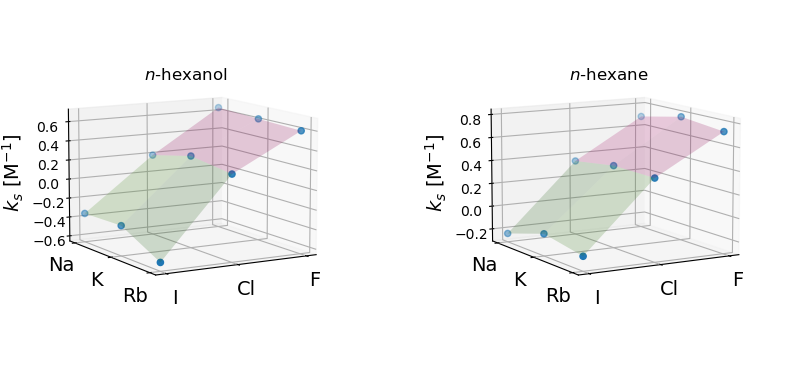

In [11]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x = np.array([0, 1, 2])
y = np.array([0, 1, 2])
X, Y =  np.meshgrid(x, y)

ax1.scatter(X, Y, SETCOF[5,:,0], zorder=1)
ax1.plot_surface(X, Y, SETCOF[5,:,0].reshape(3,3), cmap='PiYG_r', alpha=0.2, zorder=2)
ax1.set_title(f'$\it{{n}}$-hexanol', pad=-30, y=1.000001)

ax2.scatter(X, Y, SETCOF[11,:,0], zorder=1)
ax2.plot_surface(X, Y, SETCOF[11,:,0].reshape(3,3), cmap='PiYG_r', alpha=0.2, zorder=2)
ax2.set_title(f'$\it{{n}}$-hexane', pad=-30, y=1.000001)

for ax in [ax1, ax2]:
    ax.set_xticks([0, 1, 2], ['F','Cl','I'], fontsize=14)
    ax.set_yticks([0, 1, 2], ['Na','K','Rb'], fontsize=14)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('$k_s$ [M$^{-1}$]',fontsize=14, labelpad=10, rotation=90)
    ax.view_init(elev=10,azim=60)
    ax.set_box_aspect(aspect=None, zoom=0.8)
    
fig.savefig('Figures/3Dplot.pdf', bbox_inches='tight')

## Solute Excluded-Volume Contribution
The individual species contribution to the chemical potential within the energy-representation theory of solvation is given by
$$
\Delta G_{\mathrm{sol},i} = \langle \nu \rangle_{\lambda=1,i} - \int_{-\infty}^{\infty} f(\varepsilon_i) \ \mathrm{d}\varepsilon_i
$$
where the first term is the average pair-energy at $\lambda=1$ and the second term is the integration over a functional depending on the pair-energy distribution at $\lambda=0$ and $\lambda=1$. We choose to defined the excluded volume energy regime as all energies higher than the maximum pair-energy observed at $\lambda=1$. Integration over the energy coordinate in this regime reduces the above equation to
$$
\Delta G_i^{\mathrm{EV}} = \int_{\varepsilon_{\mathrm{max}}}^{\infty} f(\varepsilon_i) \ \mathrm{d}\varepsilon_i.
$$

In this section we will first determine the maximum pair-energies $\varepsilon_{\mathrm{max}}$ and second visualize the cumulative solvation free energy as a function the energy coordinate for *n*-hexane in ~1.00 M KI salt solution, to get familiar with relationship between the energy coordinate and the solvation free energy. Finally we will determine the excluded-volume contribution to the Setschenow coefficient, $k_{s}^{\mathrm{EV}}$, and it's solvent-species decomposition using the relation
$$
k_{s,i}^{\mathrm{EV}} = - \frac{1}{RT} \frac{\partial}{\partial c_{\mathrm{s}}}\left( \int_{\varepsilon_{\mathrm{max}}}^{\infty} f(\varepsilon_i) \ \mathrm{d}\varepsilon_i \right).
$$

The code for visualizing the data is utilizing the raw output files given by ERmod. Specifically the cumulative solvation free energy with the pair-energy coordinate can be found in the `cumsfe` files. The unnumbered `cumsfe` file is the average obtained from the individual blocks found in the numbered `cumsfeXX` files.  

### Obtaining $\varepsilon_{\mathrm{max}}$

Maximum pair-energy at λ=1 ranges from 4.77 to 14.6 kcal/mol.
The maximum pair-energy value is chosen to be: 15 kcal/mol.


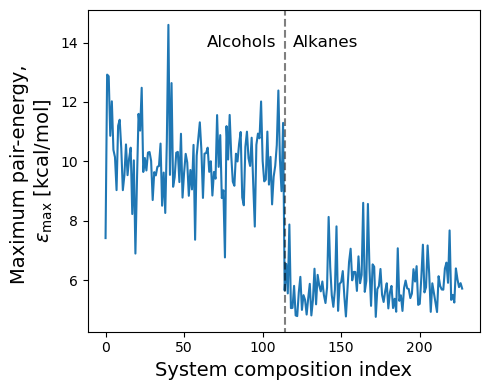

In [41]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

def round_to_multiple(number, multiple):
    return multiple * math.ceil(number / multiple)

# Determine epsilon_max
emax_list = []

for i, solute in enumerate(solutes):
    water_done = False
    for j, salt in enumerate(salts):
        for k, conc in enumerate(concentrations):
            if conc == 0 and water_done == False:
                emax = np.loadtxt('Simulations/{solute}/No_salt/soln/uvrange.tt'.format(solute=solute), usecols=(2), skiprows=2, unpack=True)
                emax_list.append(np.float64(emax))
                water_done = True
            elif conc == 0 and water_done == True:
                continue
            else:
                conc = '{0:.2f}'.format(conc)
                emax = np.loadtxt('Simulations/{solute}/{salt}/{conc}/soln/uvrange.tt'.format(solute=solute, salt=salt, conc=conc), usecols=(2), skiprows=2, unpack=True)
                emax_list.append(max(emax))

emax_list = np.asarray(emax_list)
print('Maximum pair-energy at λ=1 ranges from {:.3} to {:.3} kcal/mol.'
      .format(emax_list.min(), emax_list.max()))

EMAX = round_to_multiple(emax_list.max(), 5)
print('The maximum pair-energy value is chosen to be: {} kcal/mol.'.format(EMAX))

ax.plot(emax_list)
ax.vlines(x=len(emax_list)/2, ymin=0, ymax=20, linestyle='dashed', color='black', alpha=0.5)
ax.set_ylim(min(emax_list)-0.5, max(emax_list)+0.5)
ax.text(x=(len(emax_list)/2)-5, y=14, s='Alcohols', horizontalalignment='right', verticalalignment='center', fontsize=12)
ax.text(x=(len(emax_list)/2)+5, y=14, s='Alkanes', horizontalalignment='left', verticalalignment='center', fontsize=12)
ax.set_xlabel('System composition index', fontsize=14)
ax.set_ylabel('Maximum pair-energy, \n$\epsilon_{\mathrm{max}}$ [kcal/mol]', fontsize=14)
fig.tight_layout()
#fig.savefig('Figures/Maximum_pair_energy.pdf', bbox_inches='tight')

### Inspecting the cumulative solvation free energy with the pair-energy coordinate

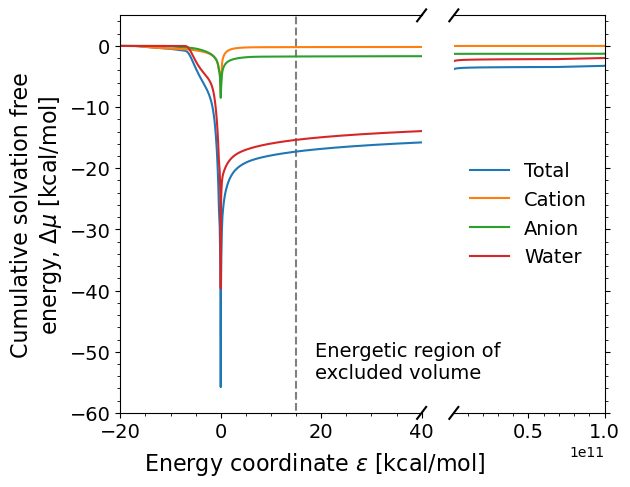

In [42]:
data = np.loadtxt('Simulations/n-hexanol/KI/1.00/cumsfe', usecols=(0,1,2,3,4))

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True, facecolor='w', gridspec_kw={'width_ratios': [2, 1]})
fig.subplots_adjust(wspace=0.05, hspace=None)

for ax in (ax1, ax2):
    ax.plot(data[:,0], data[:,1], label='Total')
    ax.plot(data[:,0], data[:,2], label='Cation')
    ax.plot(data[:,0], data[:,3], label='Anion')
    ax.plot(data[:,0], data[:,4], label='Water')

ax1.vlines(EMAX, -100, 20, linestyle='dashed', color='gray', zorder=-10)

ax1.set_xlim(-20, 40)
ax2.set_xlim(1e9,max(data[:,0]))
ax1.set_ylim(-60, 5)
ax2.set_ylim(-60, 5)

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d*2,+d*2), (1-d,1+d), **kwargs) # Adjust based on width_ratios in the x axis.
ax2.plot((-d*2,+d*2), (-d,+d), **kwargs)   # Also here.

ax1.minorticks_on()
ax2.minorticks_on()
ax2.legend(loc=5, fontsize=14, frameon=False)

fig.text(0.5, 0.2 ,f'Energetic region of \nexcluded volume', fontsize=14)
fig.text(0.5, 0.01, r'Energy coordinate $\epsilon$ [kcal/mol]', fontsize=16, ha='center')
ax1.set_ylabel(f'Cumulative solvation free\nenergy'+ r', $\Delta \mu$ [kcal/mol]', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)
fig.tight_layout()
#fig.savefig('Figures/KI_1.00M_cumsfe.pdf', bbox_inches='tight')

### Excluded-volume contribution to the Setschenow coefficient and it's solvent-species decomposition

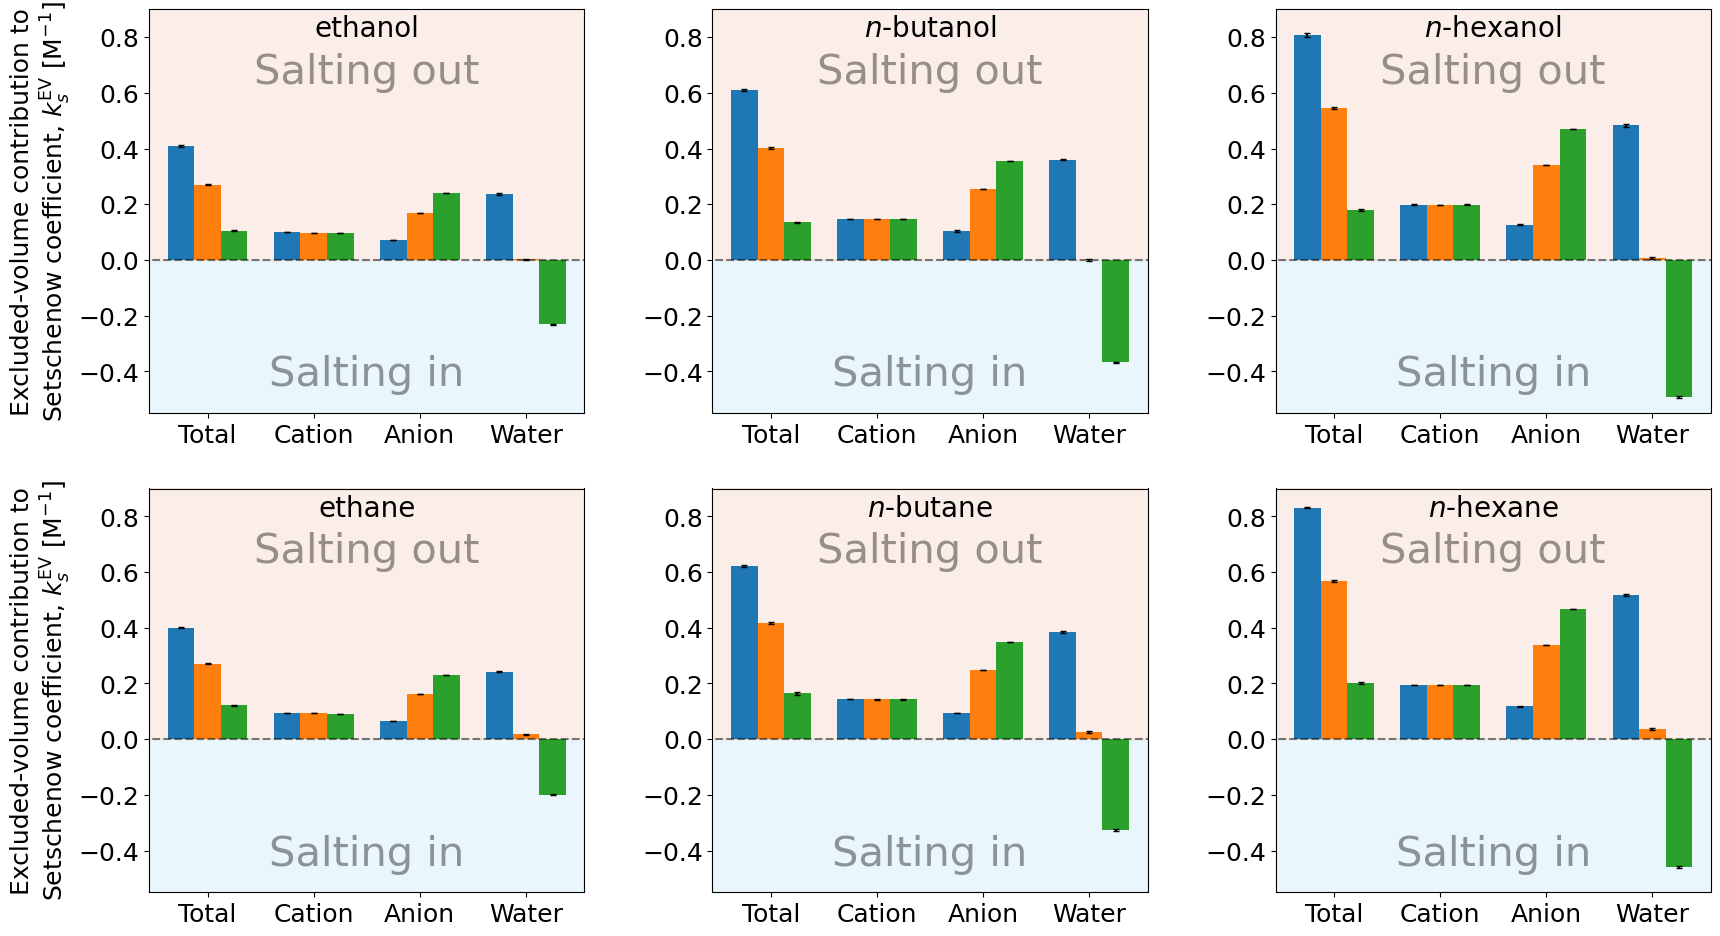

In [45]:
fig, axes = plt.subplots(2,3, figsize=(17, 10))

SETCOF_EV = np.zeros(shape=(len(solutes), len(salts), 4))
SETCOF_EV_ERR = np.zeros(shape=(len(solutes), len(salts), 4))

index = np.arange(4)
width = 0.25

col = 0
for i, solute in enumerate(solutes):
    offset = 0
    for j, salt in enumerate(salts):
        slvfes_EV = np.zeros(shape=(len(concentrations), 4, 10))
        for k, conc in enumerate(concentrations):
            for sample in range(10):
                if conc == 0: # Solute in neat water
                    data = np.loadtxt('Simulations/{}/No_salt/cumsfe{:02d}'.format(solute,sample+1),
                                      usecols=(0,1))
                    slvfes_EV[k, 0,sample] = data[-1, 1] - np.interp(EMAX, data[:,0], data[:,1])
                    slvfes_EV[k, 3,sample] = data[-1, 1] - np.interp(EMAX, data[:,0], data[:,1])
                else: # Solute in salt solution
                    C = '{0:.2f}'.format(conc)
                    data = np.loadtxt('Simulations/{}/{}/{}/cumsfe{:02d}'.format(solute, salt, C, sample+1),
                                      usecols=(0,1,2,3,4))
                    for species_idx in range(4):
                        slvfes_EV[k, species_idx,sample] = data[-1,species_idx+1] - np.interp(EMAX, data[:,0], data[:,species_idx+1])

        SetCof_EV     = np.zeros(shape=(4))
        SetCof_EV_err = np.zeros(shape=(4))
        for specie_idx in range(4):
            x = sampled_concentrations[i, j]
            y = slvfes_EV[:,specie_idx].T
            slope, intercept = BootstrapLinearRegression(x, y)
            SetCof_EV[specie_idx] = slope[0]
            SetCof_EV_err[specie_idx] = slope[1]
            
        SETCOF_EV[i,j,:] = SetCof_EV
        SETCOF_EV_ERR[i,j,:] = SetCof_EV_err
        
        if i == 7:
            col = 0
        if i%2 == 1: # Every second solute starting with ethanol
            if j >= 3 and j <= 5: # Choose potassium salts
                if i < 7:
                    row = 0
                else:
                    row = 1
                ax = axes[row,col]
                ax.bar(index+offset, SetCof_EV, width=width, alpha=1.0, yerr=SetCof_EV_err, capsize=2, zorder=2)
                offset += width
    
    if i%2 == 1: # Every second solute starting with ethanol
        ax.set_xticks(index + width)
        ax.set_xticklabels(('Total', 'Cation', 'Anion', 'Water'))
        axes[row,0].set_ylabel('Excluded-volume contribution to\nSetschenow coefficient, $k_s^{\mathrm{EV}}$ [M$^{-1}$]', fontsize=18)
        ax.tick_params(axis='both', labelsize=18)
        ax.set_xlim(-0.3, 3.8)
        ax.set_ylim(-0.55, 0.9)
        if "n-" in solute:
            s = solute.split(sep='-')[1]
            ax.set_title('$\it{{n}}$-'+s, pad=-20, y=1.001, fontsize=20)
        else:
            ax.set_title(solute, pad=-20, y=1.001, fontsize=20)
    
        ax.hlines(0, -1, 4, color='black', alpha=0.5, linestyle='dashed', zorder=2)
        ax.fill_between(np.arange(-5, 5, 0.1), [-5.2 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                        color='#c9e9f6', alpha=0.4, zorder=1)
        ax.fill_between(np.arange(-5, 5, 0.1), [4.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                        color='#f6d6c9', alpha=0.4, zorder=1)
        ax.text(1.75, -0.4125, 'Salting in', horizontalalignment='center', verticalalignment='center',
                fontsize=30, alpha=0.4, zorder=3)
        ax.text(1.75, 0.675, 'Salting out', horizontalalignment='center', verticalalignment='center',
                fontsize=30, alpha=0.4, zorder=3)
        col+=1
    

fig.tight_layout(pad=3)
fig.savefig('Figures/SetschenowExcludedVolumeDecomposition.pdf', bbox_inches='tight')

### Correlation between the excluded-volume contribution to the Setschenow coefficients and the Setschenow coefficients

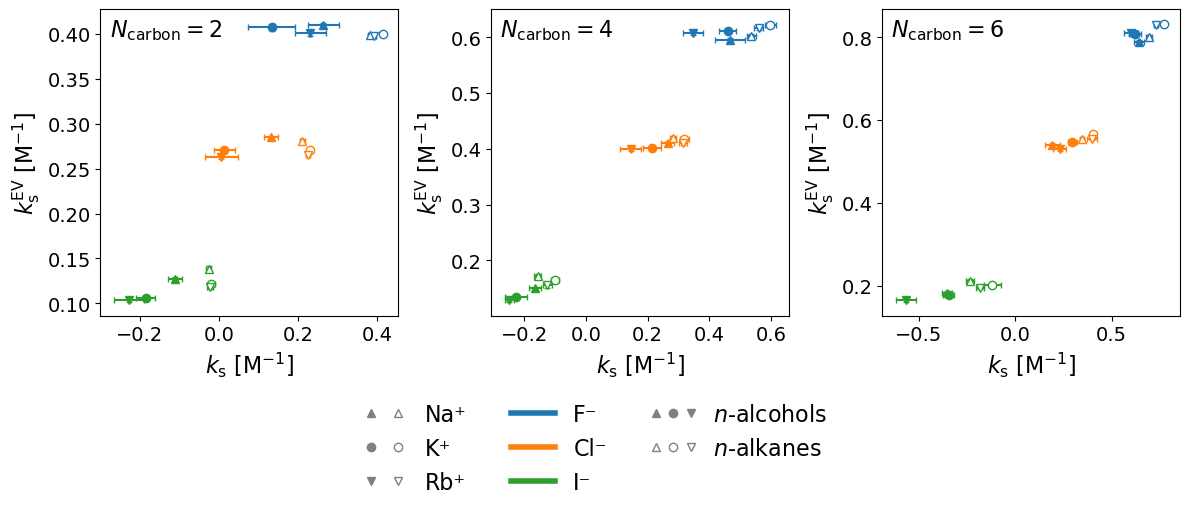

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

colors = ['C0','C1','C2']*3
symbols = ['^']*3+['o']*3+['v']*3

i = 0
for xs,ys,xerrs,yerrs in zip(SETCOF[:,:,0], SETCOF_EV[:,:,0], SETCOF_ERR[:,:,0], SETCOF_EV_ERR[:,:,0]):
    if i%6 == 1:
        ax = axes[0]
    elif i%6 == 3:
        ax = axes[1]
    elif i%6 == 5:
        ax = axes[2]
    else:
        i+=1
        continue
    if i < 6:
        for j,(x,y,xerr,yerr) in enumerate(zip(xs,ys,xerrs,yerrs)):
            ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, linestyle='None', marker=symbols[j],
                        color=colors[j], capsize=2)
    else:
        for j,(x,y,xerr,yerr) in enumerate(zip(xs,ys,xerrs,yerrs)):
            ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, linestyle='None', marker=symbols[j],
                        color=colors[j], capsize=2, mfc='white')
    i+=1


for i, ax in enumerate(axes):
    ax.set_xlabel(r'$k_{\mathrm{s}}$ [M$^{-1}$]', fontsize=16)
    ax.set_ylabel(f'$k_{{\mathrm{{s}}}}^{{\mathrm{{EV}}}}$ [M$^{{-1}}$]', fontsize=16)
#    ax.set_xlim(-0.7, 1.0)
#    ax.set_ylim(0, 0.9)
    ax.set_title(r'$N_{{\mathrm{{carbon}}}}={}$'.format((i+1)*2), pad=-20, y=1.001, x=0.22, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

handles = [(mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='v'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white')),
           mlines.Line2D([],[], color='C0', linewidth=4),
           mlines.Line2D([],[], color='C1', linewidth=4),
           mlines.Line2D([],[], color='C2', linewidth=4),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white')),
          ]

labels = ['Na⁺','K⁺','Rb⁺','F⁻', 'Cl⁻', 'I⁻',r'$\it{n}$-alcohols', r'$\it{n}$-alkanes']

fig.legend(handles, labels, frameon=False, loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.3), prop={'size': 16},
           handler_map={tuple: HandlerTuple(ndivide=None)})

fig.tight_layout()
fig.savefig('Figures/ExcludedVolumeSetschenowCorrelationEvenSeparated.pdf', bbox_inches='tight')

### Correlation between the total excluded-volume contribution and waters contribution

All data linear statistics:
r² value: 0.7236560296833985
p-value:  2.2585195672598184e-31


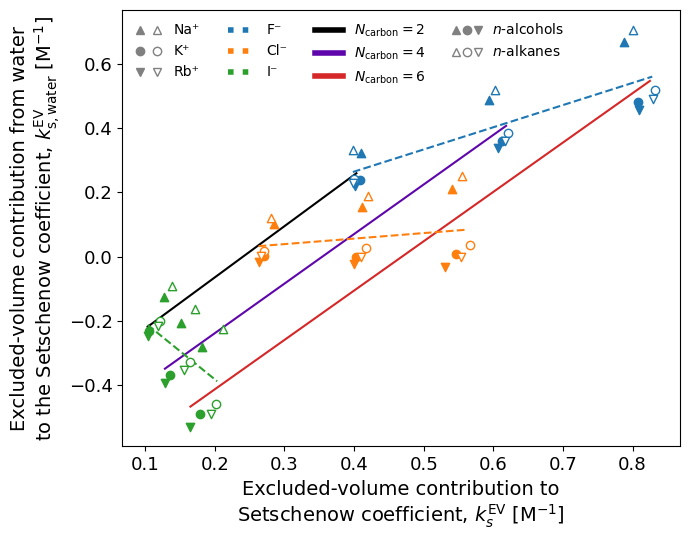

In [10]:
fig, ax = plt.subplots(figsize=(7,5.5))

excluded_outliers = False

colors = ['C0', 'C1', 'C2']*3
symbols = ['^']*3+['o']*3+['v']*3

s = stats.linregress(SETCOF_EV[:,:,0].flatten(), SETCOF_EV[:,:,3].flatten())
print('All data linear statistics:')
print('r² value: {}'.format(s.rvalue**2))
print('p-value:  {}'.format(s.pvalue))

labels = []
for solute in solutes:
    if solute.startswith('n-'):
        s = solute.split(sep="-")
        solute = f'$\it{{n}}$-'+s[1]
    labels.append(solute)

i = 0
for xs,ys,xerr,yerr in zip(SETCOF_EV[:,:,0], SETCOF_EV[:,:,3], SETCOF_EV_ERR[:,:,0], SETCOF_EV_ERR[:,:,3]):
    if i%2 == 1:
        if i > 6:
            facecolors = 'w'
        else:
            facecolors = None
        for j, (x,y) in enumerate(zip(xs, ys)):
            ax.scatter(x=x, y=y, color=colors[j], facecolors=facecolors, marker=symbols[j])
    i+=1

# Constant solute lines
colors = ['black', '#5E06AC', 'C3']
for j, i in enumerate([1,3,5]):
    x = SETCOF_EV[i::6,:,0].flatten()
    y = SETCOF_EV[i::6,:,3].flatten()
    s = stats.linregress(x,y)
    xs = np.arange(x.min(), x.max(), 0.01)
    ax.plot(xs, xs*s.slope+s.intercept, color=colors[j], zorder=0)
#    
## constant anion lines
colors = ['C0', 'C1', 'C2']
for j, i in enumerate([0,1,2]):
    x = SETCOF_EV[1::2,i::3,0].flatten()
    y = SETCOF_EV[1::2,i::3,3].flatten()
    s = stats.linregress(x,y)
    xs = np.arange(x.min(), x.max(), 0.01)
    ax.plot(xs, xs*s.slope+s.intercept, color=colors[j], zorder=0, linestyle='dashed')

ax.set_xlabel(f'Excluded-volume contribution to\nSetschenow coefficient, $k_{{s}}^{{\mathrm{{EV}}}}$ [M$^{{-1}}$]', fontsize=14)
ax.set_ylabel(f'Excluded-volume contribution from water\nto the Setschenow coefficient, $k_{{\mathrm{{s,water}}}}^{{\mathrm{{EV}}}}$ [M$^{{-1}}$]', fontsize=14)
#ax.set_xlim(0.05, 0.95)
#ax.set_ylim(-0.6, 0.6)
ax.tick_params(axis='both', labelsize=13)

handles = [(mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='v'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white')),
           mlines.Line2D([],[], color='C0', linewidth=4, linestyle='dotted'),
           mlines.Line2D([],[], color='C1', linewidth=4, linestyle='dotted'),
           mlines.Line2D([],[], color='C2', linewidth=4, linestyle='dotted'),
           mlines.Line2D([],[], color='black', linewidth=4),
           mlines.Line2D([],[], color='#5E06AC', linewidth=4),
           mlines.Line2D([],[], color='C3', linewidth=4),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white')),
          ]

labels = ['Na⁺','K⁺','Rb⁺',
          'F⁻', 'Cl⁻', 'I⁻',
          '$N_{\mathrm{carbon}}=2}$', '$N_{\mathrm{carbon}}=4}$', '$N_{\mathrm{carbon}}=6}$',
          r'$\it{n}$-alcohols', r'$\it{n}$-alkanes']

ax.legend(handles, labels, loc='best', frameon=False, ncols=4, handler_map={tuple: HandlerTuple(ndivide=None)},
          )

fig.tight_layout()
fig.savefig('Figures/WaterExcludedVolumeCorrelation.pdf', bbox_inches='tight')

### Correlation between the water excluded-volume contribution and the water molarity

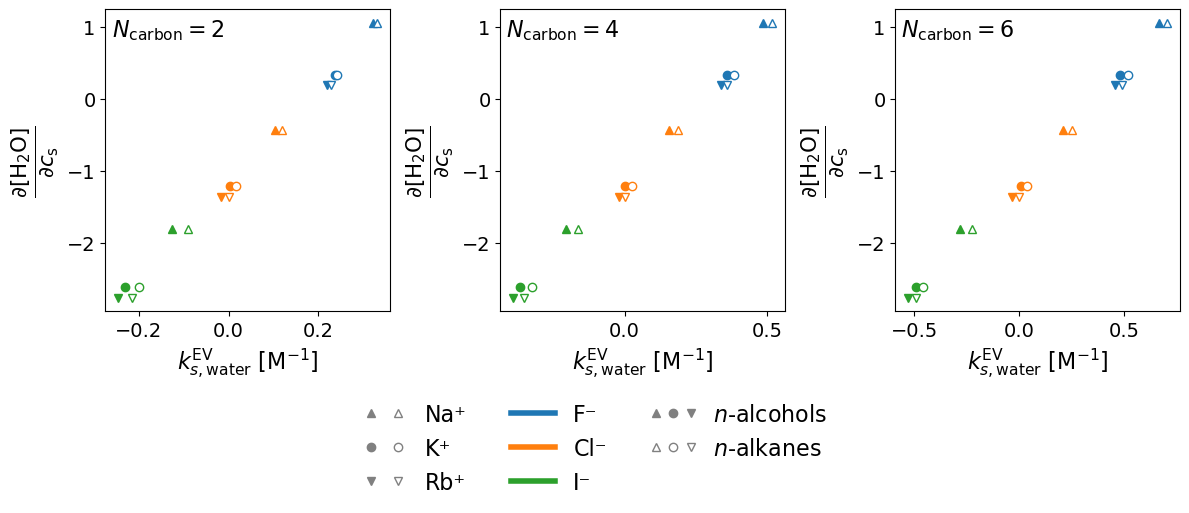

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

colors = ['C0','C1','C2']*3
symbols = ['^']*3+['o']*3+['v']*3

dC_watdCsalt = []

for j, salt in enumerate(salts):
    C_wat = []
    C_salt  = []
    for k, conc in enumerate(concentrations):
        if conc == 0: # Solute in neat water
            V = np.loadtxt('Simulations/References/No_salt/output.dat', usecols=(4), unpack=True)
        else:
            C = '{0:.2f}'.format(conc)
            V = np.loadtxt('Simulations/References/{}/{}/output.dat'.format(salt, C), usecols=(4), unpack=True)
        
        C_wat.append(10000/(V.mean()*Na*nm3_to_liter))
        if conc == 0:
            N = 0
        elif C == '0.50':
            N = 90
        elif C == '1.00':
            N = 180
        C_salt.append(N/ (V.mean()*nm3_to_liter*Na))
        
        
    s = stats.linregress(C_salt, C_wat)
    dC_watdCsalt.append(s.slope)

    
for i, xs in enumerate(SETCOF_EV[:,:,3]):
    if i%6 == 1:
        ax = axes[0]
    elif i%6 == 3:
        ax = axes[1]
    elif i%6 == 5:
        ax = axes[2]
    else:
        i+=1
        continue
    if i < 6:
        for j, x in enumerate(xs):
            ax.plot(x, dC_watdCsalt[j], linestyle='None', marker=symbols[j], color=colors[j])
    else:
        for j, x in enumerate(xs):
            ax.plot(x, dC_watdCsalt[j], linestyle='None',marker=symbols[j], color=colors[j], mfc='w')
    i+=1

for i, ax in enumerate(axes):
    ax.set_xlabel(f'$k_{{s,\mathrm{{water}}}}^{{\mathrm{{EV}}}}$ [M$^{{-1}}$]', fontsize=16)
    ax.set_ylabel(r'$\frac{\partial \left[ \mathrm{H}_2\mathrm{O} \right]}{\partial c_\mathrm{s}}$', fontsize=22)
    ax.set_title(r'$N_{{\mathrm{{carbon}}}}={}$'.format((i+1)*2), pad=-20, y=1.001, x=0.22, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

handles = [(mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='v'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white')),
           mlines.Line2D([],[], color='C0', linewidth=4),
           mlines.Line2D([],[], color='C1', linewidth=4),
           mlines.Line2D([],[], color='C2', linewidth=4),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white'))
          ]

labels = ['Na⁺','K⁺','Rb⁺','F⁻', 'Cl⁻', 'I⁻',r'$\it{n}$-alcohols', r'$\it{n}$-alkanes']

fig.legend(handles, labels, frameon=False, loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.3), prop={'size': 16},
           handler_map={tuple: HandlerTuple(ndivide=None)})
fig.tight_layout()
fig.savefig('Figures/WaterDensityCorrelationEvenSeparated.pdf', bbox_inches='tight')

## Solute-Solvent Interaction Contribution to the Setschenow Coefficient
Having in the previous looked at excluded-volume contribution, which is associated with the high-energy regime of the energy of the energy-coordinate, we now turn to the remaining of the energy coordinate. The solvation free energy in this regime is given by
$$
\Delta G_i^{\mathrm{Int}} = \langle \nu \rangle_i - \int_{-\infty}^{\varepsilon_{\mathrm{max}}} f(\varepsilon_i) \ \mathrm{d}\varepsilon_i
$$
In the above equation we see the first term is the average pair energy between the solute and solvent, thus reflecting the solute-solvent interactions introduced in the system, while the second term is the functional term which is associated with solvent reorientation by introducing the solute going from $\lambda=0$ to $\lambda=1$. These two terms can be treated together or independently.


###  Partial contribution from the solute-solvent interactions and the associated solvent reorganization to the Setschenow coefficient and it's solvent-species decomposition
In the following code we will now compute the Setschenow coefficient using the solute-solvent interaction component of the free energy of solvation for the chemical species.


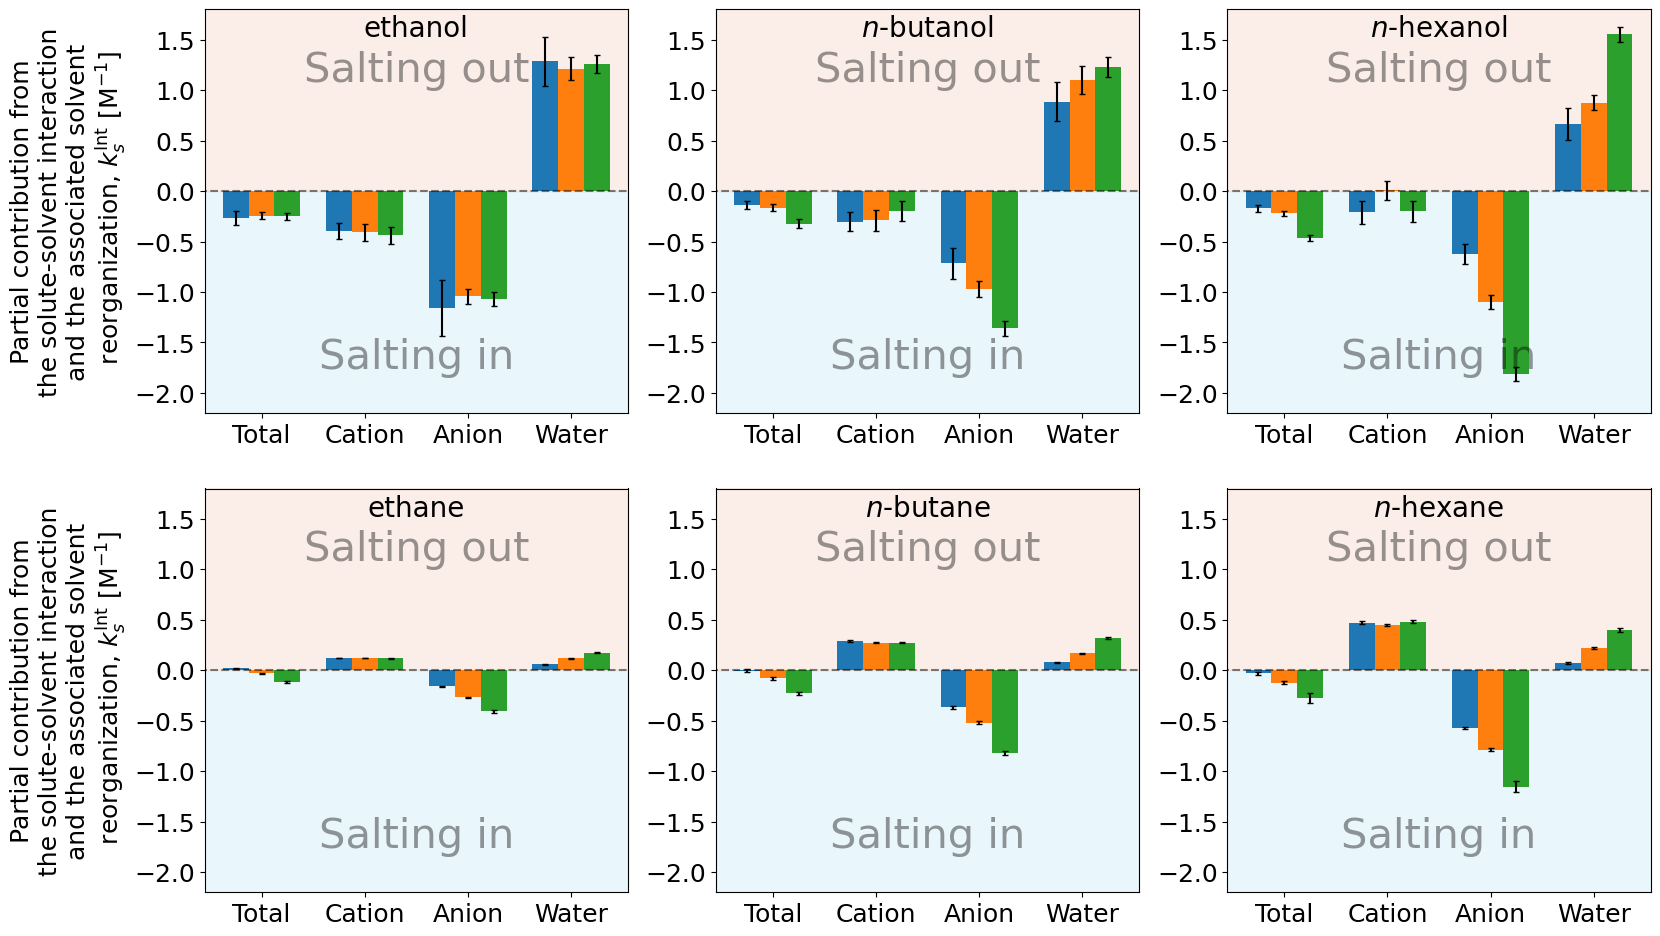

In [58]:
fig, axes = plt.subplots(2,3, figsize=(17, 10))

SETCOF_INT = np.zeros(shape=(len(solutes), len(salts), 4))
SETCOF_INT_ERR = np.zeros(shape=(len(solutes), len(salts), 4))

index = np.arange(4)
width = 0.25

col = 0
for i, solute in enumerate(solutes):
    offset = 0
    for j, salt in enumerate(salts):
        slvfes_Int = np.zeros(shape=(len(concentrations), 4, 10))
        for k, conc in enumerate(concentrations):
            for sample in range(10):
                if conc == 0: # Solute in neat water
                    data = np.loadtxt('Simulations/{}/No_salt/cumsfe{:02d}'.format(solute,sample+1),
                                      usecols=(0,1))
                    slvfes_Int[k, 0,sample] = np.interp(EMAX, data[:,0], data[:,1])
                    slvfes_Int[k, 3,sample] = np.interp(EMAX, data[:,0], data[:,1])
                else: # Solute in salt solution
                    C = '{0:.2f}'.format(conc)
                    data = np.loadtxt('Simulations/{}/{}/{}/cumsfe{:02d}'.format(solute, salt, C, sample+1),
                                      usecols=(0,1,2,3,4))
                    for species_idx in range(4):
                        slvfes_Int[k, species_idx,sample] = np.interp(EMAX, data[:,0], data[:,species_idx+1])

        SetCof_Int     = np.zeros(shape=(4))
        SetCof_Int_err = np.zeros(shape=(4))
        for specie_idx in range(4):
            x = sampled_concentrations[i, j]
            y = slvfes_Int[:,specie_idx].T
            slope, intercept = BootstrapLinearRegression(x, y)
            SetCof_Int[specie_idx] = slope[0]
            SetCof_Int_err[specie_idx] = slope[1]
            
        SETCOF_INT[i,j,:] = SetCof_Int
        SETCOF_INT_ERR[i,j,:] = SetCof_Int_err
        
        if i == 7:
            col = 0
        if i%2 == 1: # Every second solute starting with ethanol
            if j >= 3 and j <= 5: # Choose potassium salts
                if i < 7:
                    row = 0
                else:
                    row = 1
                ax = axes[row,col]
                ax.bar(index+offset, SetCof_Int, width=width, alpha=1.0, yerr=SetCof_Int_err, capsize=2, zorder=2)
                offset += width
                
    if i%2 == 1:
        ax.set_xticks(index + width)
        ax.set_xticklabels(('Total', 'Cation', 'Anion', 'Water'))
        axes[row,0].set_ylabel('Partial contribution from\nthe solute-solvent interaction\nand the associated solvent\n reorganisation, $k_{{s}}^{{\mathrm{{Int}}}}$ [M$^{{-1}}$]', fontsize=18)
        ax.tick_params(axis='both', labelsize=18)
        ax.set_xlim(-0.3, 3.8)
        ax.set_ylim(-2.2, 1.8)
        if "n-" in solute:
            s = solute.split(sep='-')[1]
            ax.set_title('$\it{{n}}$-'+s, pad=-20, y=1.001, fontsize=20)
        else:
            ax.set_title(solute, pad=-20, y=1.001, fontsize=20)
    
        ax.hlines(0, -1, 4, color='black', alpha=0.5, linestyle='dashed', zorder=2)
        ax.fill_between(np.arange(-5, 5, 0.1), [-5.2 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                        color='#c9e9f6', alpha=0.4, zorder=1)
        ax.fill_between(np.arange(-5, 5, 0.1), [4.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                        color='#f6d6c9', alpha=0.4, zorder=1)
        ax.text(1.75, -1.65, 'Salting in', horizontalalignment='center', verticalalignment='center',
                fontsize=30, alpha=0.4, zorder=3)
        ax.text(1.75, 1.20, 'Salting out', horizontalalignment='center', verticalalignment='center',
                fontsize=30, alpha=0.4, zorder=3)
        col+=1
    
fig.tight_layout(pad=3)
fig.savefig('Figures/SetschenowInteractionDomainDecomposition.pdf', bbox_inches='tight')

### Correlation between the solute-solvent interactions and the associated solvent reorganization to the Setschenow coefficients and the Setschenow coefficients

All data linear statistics:
r² value: 0.598101530854952
p-value:  1.0360480702055742e-22


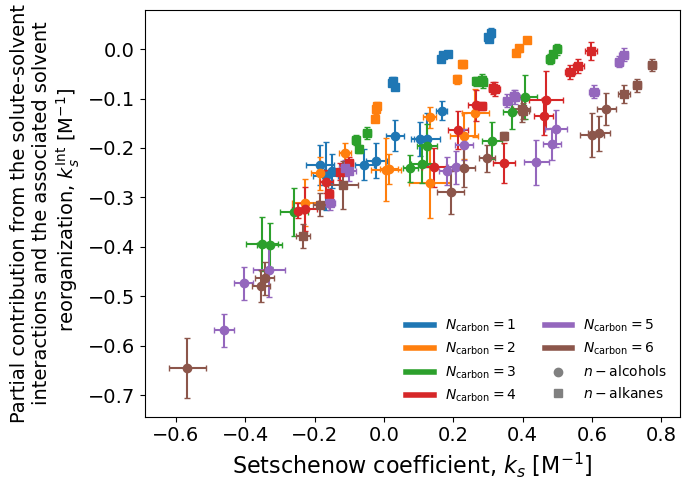

In [49]:
fig, ax = plt.subplots(figsize=(7,5))

symbols = ['o' for i in range(6)] + ['s' for i in range(6)]

s = stats.linregress(SETCOF[:,:,0].flatten(), SETCOF_INT[:,:,0].flatten())
print('All data linear statistics:')
print('r² value: {}'.format(s.rvalue**2))
print('p-value:  {}'.format(s.pvalue))

i = 0
for x,y,xerr,yerr in zip(SETCOF[:,:,0], SETCOF_INT[:,:,0], SETCOF_ERR[:,:,0], SETCOF_INT_ERR[:,:,0]):
    ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, linestyle='None', marker='{}'.format(symbols[i]),
                color='C{}'.format(i%6), capsize=2)
    i+=1
    
ax.set_xlabel(r'Setschenow coefficient, $k_s$ [M$^{-1}$]', fontsize=16)
ax.set_ylabel(f'Partial contribution from the solute-solvent\ninteraction and the associated solvent\n reorganisation, $k_{{s}}^{{\mathrm{{Int}}}}$ [M$^{{-1}}$]', fontsize=14)
ax.tick_params(axis='both', labelsize=14)

handles = [mlines.Line2D([],[], color='C0', linewidth=4),
           mlines.Line2D([],[], color='C1', linewidth=4),
           mlines.Line2D([],[], color='C2', linewidth=4),
           mlines.Line2D([],[], color='C3', linewidth=4),
           mlines.Line2D([],[], color='C4', linewidth=4),
           mlines.Line2D([],[], color='C5', linewidth=4),
           mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
           mlines.Line2D([],[], color='gray', linewidth=0, marker='s'),
          ]

labels = ['$N_{\mathrm{carbon}}='+str(i)+'}$' for i in range(1,7)]+[r'$\it{n}-\mathrm{alcohols}$', r'$\it{n}-\mathrm{alkanes}$']

ax.legend(handles, labels, ncols=2, frameon=False)

fig.tight_layout()
#fig.savefig('Figures/SetschenowInteractionDomainCorrelation.pdf', bbox_inches='tight')

### Mean interaction only
In the previous we looked at how the contribution from the mean solute-solvent interactions and the functional varied with different salts and concentrations. In the following we will now mean solute-solvent interaction term exclusively.
### Species decomposition of the mean solute-solvent interaction variation with salt concentration

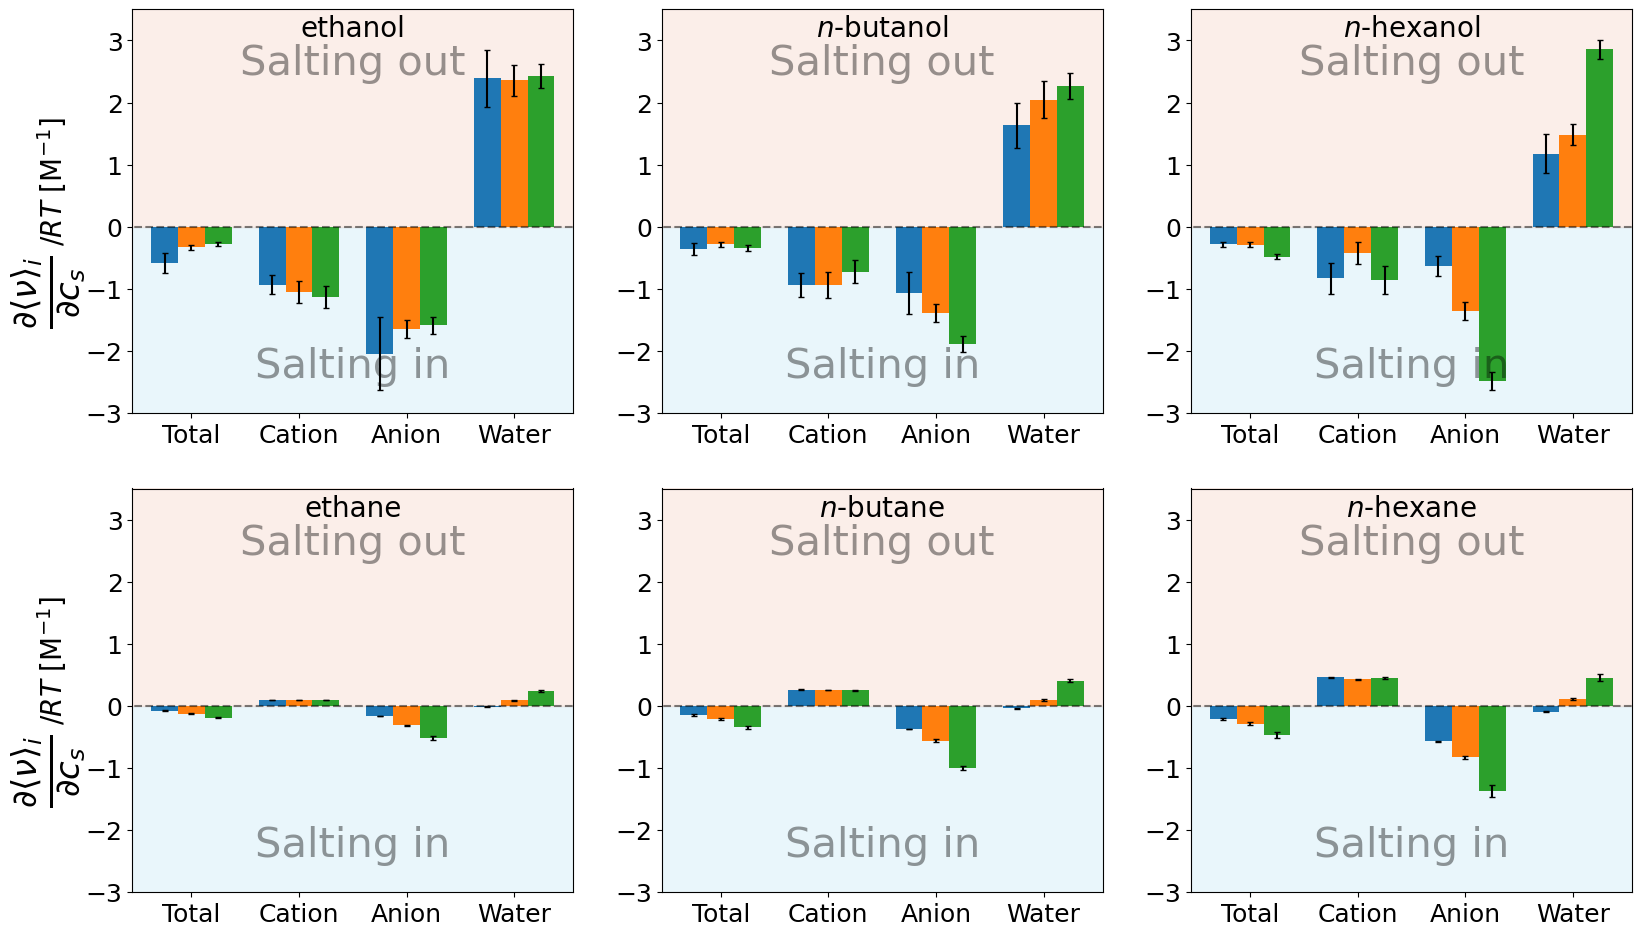

In [61]:
fig, axes = plt.subplots(2,3, figsize=(17, 10))

SETCOF_AVGUV = np.zeros(shape=(len(solutes), len(salts), 4))
SETCOF_AVGUV_ERR = np.zeros(shape=(len(solutes), len(salts), 4))

index = np.arange(4)
width = 0.25

col = 0
for i, solute in enumerate(solutes):
    offset = 0
    for j, salt in enumerate(salts):
        slvfes_avguv = np.zeros(shape=(len(concentrations), 4, 10))
        for k, conc in enumerate(concentrations):
            if conc == 0: # Solute in neat water
                data = np.loadtxt('Simulations/{}/No_salt/soln/aveuv.tt'.format(solute), usecols=(1))
                slvfes_avguv[k, 0,:] = data
                slvfes_avguv[k, 3,:] = data
            else: # Solute in salt solution
                C = '{0:.2f}'.format(conc)
                data = np.loadtxt('Simulations/{}/{}/{}/soln/aveuv.tt'.format(solute, salt, C), usecols=(1,2,3))
                slvfes_avguv[k,0,:] = data.sum(axis=1)
                slvfes_avguv[k,1:]= data.T

        SetCof_avguv     = np.zeros(shape=(4))
        SetCof_avguv_err = np.zeros(shape=(4))
        for specie_idx in range(4):
            x = sampled_concentrations[i, j]
            y = slvfes_avguv[:,specie_idx].T
            slope, intercept = BootstrapLinearRegression(x, y)
            SetCof_avguv[specie_idx] = slope[0]
            SetCof_avguv_err[specie_idx] = slope[1]
            
        SETCOF_AVGUV[i,j,:] = SetCof_avguv
        SETCOF_AVGUV_ERR[i,j,:] = SetCof_avguv_err
        
        if i == 7:
            col = 0
        if i%2 == 1: # Every second solute starting with ethanol
            if j >= 3 and j <= 5: # Choose potassium salts
                if i < 7:
                    row = 0
                else:
                    row = 1
                ax = axes[row,col]
                ax.bar(index+offset, SetCof_avguv, width=width, alpha=1.0, yerr=SetCof_avguv_err, capsize=2, zorder=2)
                offset += width
                
    if i%2 == 1:
        ax.set_xticks(index + width)
        ax.set_xticklabels(('Total', 'Cation', 'Anion', 'Water'))
        axes[row,0].set_ylabel(r'$\frac{\partial \langle \nu \rangle_{i}}{\partial c_s}$', fontsize=35)
        ax.tick_params(axis='both', labelsize=18)
        ax.set_xlim(-0.3, 3.8)
        ax.set_ylim(-3, 3.5)
        if "n-" in solute:
            s = solute.split(sep='-')[1]
            ax.set_title('$\it{{n}}$-'+s, pad=-20, y=1.001, fontsize=20)
        else:
            ax.set_title(solute, pad=-20, y=1.001, fontsize=20)
    
        ax.hlines(0, -1, 4, color='black', alpha=0.5, linestyle='dashed', zorder=2)
        ax.fill_between(np.arange(-5, 5, 0.1), [-5.2 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                        color='#c9e9f6', alpha=0.4, zorder=1)
        ax.fill_between(np.arange(-5, 5, 0.1), [4.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                        color='#f6d6c9', alpha=0.4, zorder=1)
        ax.text(1.75, -2.25, 'Salting in', horizontalalignment='center', verticalalignment='center',
                fontsize=30, alpha=0.4, zorder=3)
        ax.text(1.75, 2.625, 'Salting out', horizontalalignment='center', verticalalignment='center',
                fontsize=30, alpha=0.4, zorder=3)
        col+=1

# Super ugly hack
axes[0,0].yaxis.set_label_coords(-0.1,0.3)
axes[0,0].text(-1.2, -0.2, '$/RT$ [M$^{-1}$]', fontsize=20, rotation=90)
axes[1,0].yaxis.set_label_coords(-0.1,0.3)
axes[1,0].text(-1.2, -0.2, '$/RT$ [M$^{-1}$]', fontsize=20, rotation=90)
    
fig.tight_layout(pad=3)
fig.savefig('Figures/SetschenowMeanInteractionDecomposition.pdf', bbox_inches='tight')

### Correlation between the solute-anion interaction variation with salt concentration and the Setschenow coefficient

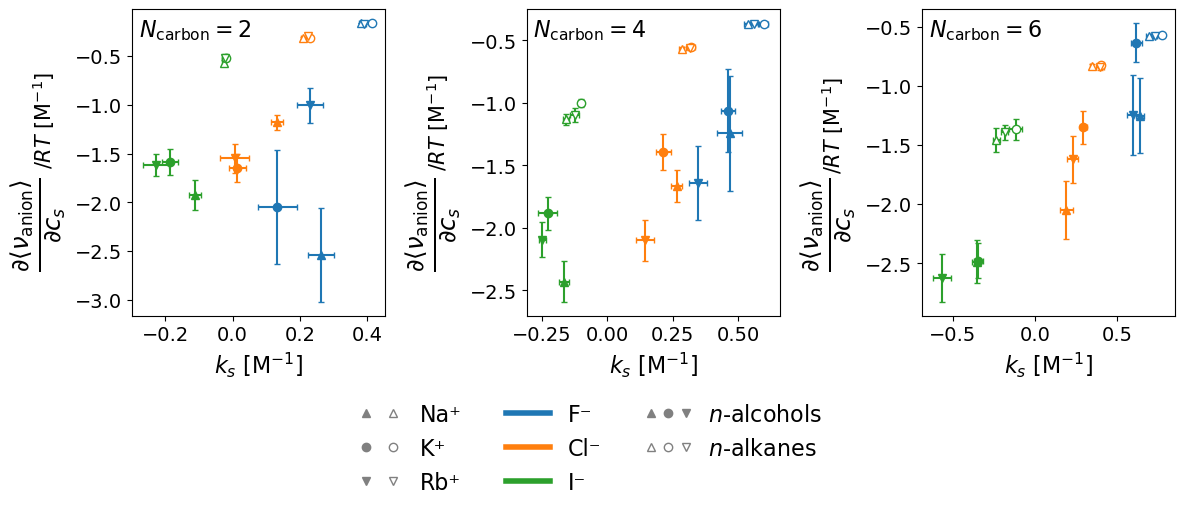

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

i = 0
for xs,ys,xerrs,yerrs in zip(SETCOF[:,:,0], SETCOF_AVGUV[:,:,2], SETCOF_ERR[:,:,0], SETCOF_AVGUV_ERR[:,:,2]):
    if i%6 == 1:
        ax = axes[0]
    elif i%6 == 3:
        ax = axes[1]
    elif i%6 == 5:
        ax = axes[2]
    else:
        i+=1
        continue
    if i < 6:
        for j, (x,y,xerr,yerr) in enumerate(zip(xs,ys,xerrs,yerrs)):
            ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, linestyle='None', marker=symbols[j], color=colors[j],
                        capsize=2)
    else:
        for j, (x,y,xerr,yerr) in enumerate(zip(xs,ys,xerrs,yerrs)):
            ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, linestyle='None', marker=symbols[j], color=colors[j],
                        capsize=2, mfc='w')
    i+=1


for i, ax in enumerate(axes):
    ax.set_xlabel(f'$k_{{s}}$ [M$^{{-1}}$]', fontsize=16)
    ax.set_ylabel(r'$\frac{\partial \langle \nu_{\mathrm{anion}} \rangle}{\partial c_s}$', fontsize=25)
    ax.yaxis.set_label_coords(-0.25,0.3)
    ax.set_title(r'$N_{{\mathrm{{carbon}}}}={}$'.format((i+1)*2), pad=-20, y=1.001, x=0.25, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

handles = [(mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='v'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white')),
           mlines.Line2D([],[], color='C0', linewidth=4),
           mlines.Line2D([],[], color='C1', linewidth=4),
           mlines.Line2D([],[], color='C2', linewidth=4),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white'))
          ]

labels = ['Na⁺','K⁺','Rb⁺','F⁻', 'Cl⁻', 'I⁻',r'$\it{n}$-alcohols', r'$\it{n}$-alkanes']

axes[0].text(-.6,-1.6, '$/RT$ [M$^{-1}$]', fontsize=15, rotation=90)
axes[1].text(-0.7,-1.5, '$/RT$ [M$^{-1}$]', fontsize=15, rotation=90)
axes[2].text(-1.31,-1.7, '$/RT$ [M$^{-1}$]', fontsize=15, rotation=90)

fig.legend(handles, labels, frameon=False, loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.3), prop={'size': 16},
           handler_map={tuple: HandlerTuple(ndivide=None)})
fig.tight_layout()
fig.savefig('Figures/AvgUVAnionSetschenowCorrelationEvenSeparated.pdf', bbox_inches='tight')

### Correlation between the solute-water interaction variation with salt concentration and the Setschenow coefficient

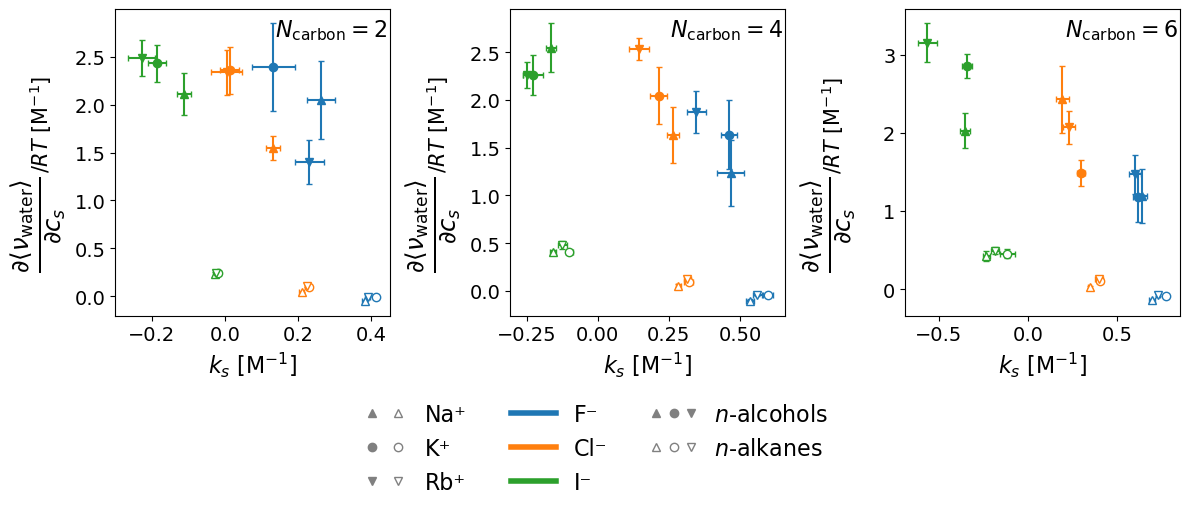

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

i = 0
for xs,ys,xerrs,yerrs in zip(SETCOF[:,:,0], SETCOF_AVGUV[:,:,3], SETCOF_ERR[:,:,0], SETCOF_AVGUV_ERR[:,:,3]):
    if i%6 == 1:
        ax = axes[0]
    elif i%6 == 3:
        ax = axes[1]
    elif i%6 == 5:
        ax = axes[2]
    else:
        i+=1
        continue
    if i < 6:
        for j, (x,y,xerr,yerr) in enumerate(zip(xs,ys,xerrs,yerrs)):
            ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, linestyle='None', marker=symbols[j], color=colors[j],
                        capsize=2)
    else:
        for j, (x,y,xerr,yerr) in enumerate(zip(xs,ys,xerrs,yerrs)):
            ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, linestyle='None', marker=symbols[j], color=colors[j],
                        capsize=2, mfc='w')
    i+=1


for i, ax in enumerate(axes):
    ax.set_xlabel(f'$k_{{s}}$ [M$^{{-1}}$]', fontsize=16)
    ax.set_ylabel(r'$\frac{\partial \langle \nu_{\mathrm{water}} \rangle}{\partial c_s}$', fontsize=25)
    ax.set_title(r'$N_{{\mathrm{{carbon}}}}={}$'.format((i+1)*2), pad=-20, y=1.001, x=0.785, fontsize=16)
    ax.yaxis.set_label_coords(-0.17,0.3)
    ax.tick_params(axis='both', labelsize=14)
    
axes[0].text(-.54,1.35, '$/RT$ [M$^{-1}$]', fontsize=15, rotation=90)
axes[1].text(-0.61,1.30, '$/RT$ [M$^{-1}$]', fontsize=15, rotation=90)
axes[2].text(-1.17,1.55, '$/RT$ [M$^{-1}$]', fontsize=15, rotation=90)

handles = [(mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='v'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white')),
           mlines.Line2D([],[], color='C0', linewidth=4),
           mlines.Line2D([],[], color='C1', linewidth=4),
           mlines.Line2D([],[], color='C2', linewidth=4),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v')),
           (mlines.Line2D([],[], color='gray', linewidth=0, marker='^', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='o', mfc='white'),
            mlines.Line2D([],[], color='gray', linewidth=0, marker='v', mfc='white'))
          ]

labels = ['Na⁺','K⁺','Rb⁺','F⁻', 'Cl⁻', 'I⁻',r'$\it{n}$-alcohols', r'$\it{n}$-alkanes']

fig.legend(handles, labels, frameon=False, loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.3), prop={'size': 16},
           handler_map={tuple: HandlerTuple(ndivide=None)})
fig.tight_layout()
fig.savefig('Figures/AvgUVWaterSetschenowCorrelationEvenSeparated.pdf', bbox_inches='tight')

## Liquid Structure Analysis - Radial Distribution Functions

In [4]:
for salt in ['KF', 'KCl', 'KI']:
    anion = salt.split(sep='K')[1]
    rdf_Anion = np.zeros(shape=(50,180))
    rdf_K = np.zeros(shape=(50,180))
    rdf_WAT = np.zeros(shape=(50,180))
    
    for i in range(50):
        traj = md.load_xtc('/data4/stefan/Cavity-Formation/Simulations/n-hexane/{}/rdf_1.00/{}/trajectory.xtc'.format(salt,i),
                           top='/data4/stefan/Cavity-Formation/Simulations/n-hexane/{}/rdf_1.00/{}/Initial.pdb'.format(salt,i))
        
        # Anion-solute RDF
        pairs = traj.topology.select_pairs(selection1='resid 0 and type C', selection2='type {}'.format(anion))
        rdf = md.compute_rdf(traj, pairs, r_range=(0.2, 2), bin_width=0.01)
        rdf_Anion[i] = rdf[1]
        
        # Cation-solute RDF
        pairs = traj.topology.select_pairs(selection1='resid 0 and type C', selection2='type K')
        rdf = md.compute_rdf(traj, pairs, r_range=(0.2, 2), bin_width=0.01)
        rdf_K[i] = rdf[1]
        
        # Water-solute RDF
        pairs = traj.topology.select_pairs(selection1='resid 0 and type C', selection2='water and type O')
        rdf = md.compute_rdf(traj, pairs, r_range=(0.2, 2), bin_width=0.01)
        rdf_WAT[i] = rdf[1]
        
    np.save('Data/RDF_Hexane-{}_{}_1.00M.npy'.format(anion, salt), rdf_Anion)
    np.save('Data/RDF_Hexane-K_{}_1.00M.npy'.format(salt), rdf_K)
    np.save('Data/RDF_Hexane-WAT_{}_1.00M.npy'.format(salt), rdf_WAT)

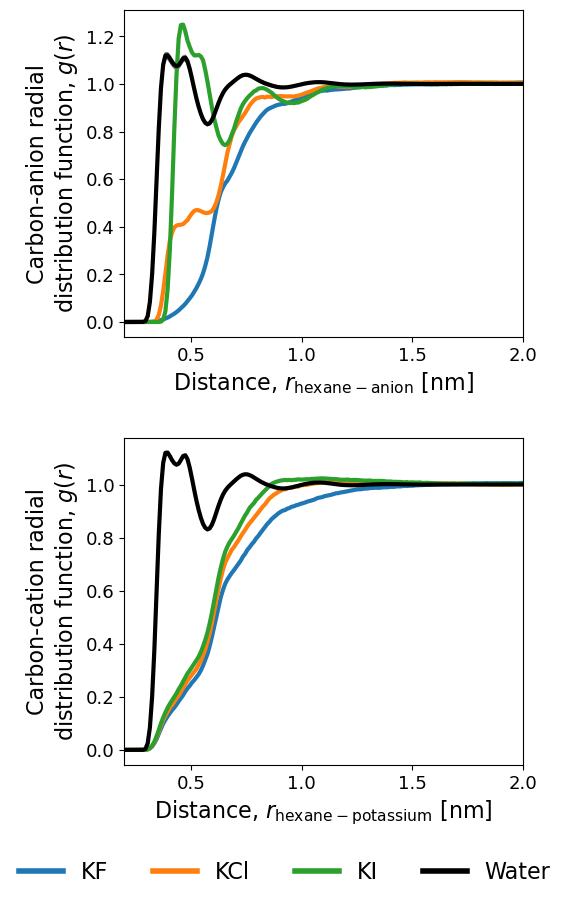

In [2]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,9))


for anion in ['F', 'Cl', 'I']:
    anion_rdf = np.load('Data/RDF_Hexane-{anion}_K{anion}_1.00M.npy'.format(anion=anion))
    potassium_rdf = np.load('Data/RDF_Hexane-K_K{anion}_1.00M.npy'.format(anion=anion))
    
    x = np.arange(0.2, 2.01, 0.01)
    x = 0.5 * (x[1:] + x[:-1])
    
    for i,rdf in enumerate([anion_rdf, potassium_rdf]):
        axes[i].plot(x, rdf.mean(axis=0), linewidth=3)

    
water_rdf = np.empty(shape=(3, 50, 180))
for i, anion in enumerate(['F', 'Cl', 'I']):
    water_rdf[i] = np.load('Data/RDF_Hexane-WAT_K{anion}_1.00M.npy'.format(anion=anion))
        
for i, ax in enumerate(axes):
    ax.plot(x, water_rdf.mean(axis=(0,1)), color='black', linewidth=3)
    ax.set_xlim(0.2, 2)
    ax.tick_params(axis='both', labelsize=13)

axes[0].set_xlabel('Distance, $r_{\mathrm{hexane - anion}}$ [nm]', fontsize=16)
axes[0].set_ylabel('Carbon-anion radial\ndistribution function, $g(r)$', fontsize=16)
axes[1].set_xlabel('Distance, $r_{\mathrm{hexane - potassium}}$ [nm]', fontsize=16)
axes[1].set_ylabel('Carbon-cation radial\ndistribution function, $g(r)$', fontsize=16)

handles = [mlines.Line2D([],[], color='C0', linewidth=4),
           mlines.Line2D([],[], color='C1', linewidth=4),
           mlines.Line2D([],[], color='C2', linewidth=4),
           mlines.Line2D([],[], color='black', linewidth=4),
          ]

for i in ('RDF_Hexane-WAT_KCl_1.00M.npy', 'RDF_Hexane-WAT_KF_1.00M.npy', 'RDF_Hexane-WAT_KI_1.00M.npy'):
    d = np.load('Data/{}'.format(i))
    axes[0].plot(x, d.mean(axis=0), color='gray', zorder=0)

labels = ['KF', 'KCl', 'KI', 'Water']

fig.legend(handles, labels, frameon=False, loc='lower center', ncols=4, bbox_to_anchor=(0.5, -0.04), prop={'size': 16})

fig.tight_layout(pad=3)
fig.savefig('Figures/Hexane_rdfs.pdf', bbox_inches='tight')